<a href="https://colab.research.google.com/github/ErikaRochadeAraujo/3D_Unet_com_Perda_Personalizada/blob/main/3D_Unet_com_Perda_Personalizada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentação de Imagens de Ressonância Magnética de Tumor Cerebral Utilizando o Modelo 3D U-Net**



In [ ]:
!pip install nilearn
!pip install keras

In [ ]:
### https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# imagem neural
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
#!pip install git+https://github.com/miykael/gif_your_nifti    # nifti to gif
#import gif_your_nifti.core as gif2nif
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# ml libs
import keras
import keras.backend as K
from keras.losses import CategoricalCrossentropy
from keras.losses import Loss
from keras.callbacks import CSVLogger
import tensorflow as tf
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
#from keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.  #Torne as impressões numpy mais fáceis de ler.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# DEFINIR áreas segmentadas
SEGMENT_CLASSES = {
    0 : 'Sem tumor',
    1 : 'Tumor sem realce', # or NON-ENHANCING tumor CORE
    2 : 'Edema',
    3 : 'Tumor com realce' # original 4 -> converted into 3 later
}

# existem 155 fatias por volume
# começar em 5 e usar 145 fatias significa que pularemos as 5 primeiras e as 5 últimas
VOLUME_SLICES = 100 #FATIAS DE VOLUME
VOLUME_START_AT = 22 # first slice of volume that we will include #VOLUME INICIAR EM #primeira fatia do volume que incluiremos

In [ ]:
#Endereço das imagens
DATA_PATH = '/content/drive/MyDrive/IRM/Task01_BrainTumour/archive'
TRAIN_PATH = f'{DATA_PATH}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

#Numero da imagem que será estudada

numcase = 9

In [ ]:
# Montando o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from glob import glob

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from matplotlib import animation, cm, colors, rc
from scipy import ndimage





#TEST_PATH = f'{DATA_PATH}/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
DATA_TYPES = ['flair', 't1', 't1ce', 't2', 'seg']
MASK_LABELS = ['Edema', 'Tumor com realce', 'Tumor com realce']
MASK_VALUES = [0, 1, 2, 4]



train_data_paths = {
    data_type: sorted(
        glob(f'{TRAIN_PATH}/**/*_{data_type}.nii')
    ) for data_type in DATA_TYPES
}
train_data_paths['seg'].append(f'{TRAIN_PATH}/BraTS20_Training_355/W39_1998.09.19_Segm.nii')
train_data_paths['seg'] = sorted(train_data_paths['seg'])

for k, v in train_data_paths.items():
    print(f'[TRAIN] Number of {k} images: {len(v)}')
print()
#test_data_paths = {
#    data_type: sorted(
#        glob(f'{TEST_PATH}/**/*_{data_type}.nii')
#    ) for data_type in DATA_TYPES
#}

#for k, v in test_data_paths.items():
#    print(f'[TEST] Number of {k} images: {len(v)}')







[TRAIN] Number of flair images: 369
[TRAIN] Number of t1 images: 369
[TRAIN] Number of t1ce images: 369
[TRAIN] Number of t2 images: 369
[TRAIN] Number of seg images: 369



In [ ]:
#https://www.kaggle.com/code/mariuszwisniewski/brats2020-eda-and-data-visualization

#Verificação de Máscaras Ausentes
for path in sorted(glob(f'{TRAIN_PATH}/*')):
    if os.path.isdir(path):
        if not any(f.endswith('seg.nii') or f.endswith('Segm.nii') for f in os.listdir(path)):
            print(
                f'Máscara de segmentação ausente por volume: {path.split("/")[-1]}.')

#Verificação de Dados Incorretos
for path in train_data_paths[DATA_TYPES[-1]]:
    volume = np.asanyarray(nib.load(path).dataobj)
    if not np.any(np.isin(np.unique(volume), MASK_VALUES)):
        print(f'Volume {path} tem dados incorretos.')
        print(f'Min val: {np.min(volume)}, max val: {np.max(volume)}')

#Verificação de Máscaras Incompletas
unique_values_per_mask = {
    int(path.split('_')[-2] if path.split('_')[-2] != '1998.09.19' else '355'): np.unique(
        np.asanyarray(nib.load(path).dataobj)
    ) for path in train_data_paths[DATA_TYPES[-1]]
}

number_of_incomplete_masks = sum(
    [1 for _, v in unique_values_per_mask.items() if set(v) != set(MASK_VALUES)]
)
print(
    f'Número de máscaras incompletas: {number_of_incomplete_masks} ({number_of_incomplete_masks / len(unique_values_per_mask) * 100:.2f}%)')

Número de máscaras incompletas: 29 (7.86%)


In [ ]:
#verificando se todos os elementos na lista train_shapes têm o mesmo comprimento
train_shapes = [
    np.asanyarray(nib.load(f).dataobj).shape
    for data_type in DATA_TYPES for f in train_data_paths[data_type]
]

#test_shapes = [
#    np.asanyarray(nib.load(f).dataobj).shape
#    for data_type in DATA_TYPES for f in test_data_paths[data_type]
#]


assert len(set(train_shapes)) == 1
#assert len(set(test_shapes)) == 1
#assert train_shapes[0] == test_shapes[0]
print(f'Volume dimensions: {train_shapes[0]}')

Volume dimensions: (240, 240, 155)


In [ ]:
# Defina o novo limite de incorporação em MB (aumente conforme necessário)
new_embed_limit = 30.0  # Exemplo: 30 MB

# Atualize o limite de incorporação
plt.rcParams['animation.embed_limit'] = new_embed_limit * 1024 * 1024  # Converta para bytes


def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet.
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1, ki],
                       colors_rgba[i, ki]) for i in range(N+1)]
    return colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)


rc('animation', html='jshtml')


def create_half_animation(halves, case):
    """Create an animation of two halves of a volume"""
    halves = [np.transpose(half, (2, 0, 1)) for half in halves]
    fig = plt.figure(figsize=(8, 8))
    plt.tight_layout()
    plt.axis('off')
    plt.suptitle(f'Patient ID: {case}', fontsize=16, fontweight='bold')

    axes = []
    for idx, data_type in enumerate(halves):
        ax = fig.add_subplot(1, 2, idx + 1)
        ax.set_title('Left Half' if idx == 0 else 'Right Half', weight='bold')
        axes.append(ax)

    images = []
    for i, slices in enumerate(zip(*halves)):
        aux_imgs = []
        for idx, s in enumerate(slices):
            im = axes[idx].imshow(s, animated=True, cmap='bone')
            aux_imgs.append(im)
        images.append(aux_imgs)

    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(halves[0]), blit=False, repeat_delay=1000)
    plt.close()
    return ani


def create_parallel_animation(volumes, case, show_mask=False, alpha=0.6):
    """Create animation of multiple volumes"""
    # transpose volume from (x, y, z) to (z, x, y)
    volumes = np.array([np.transpose(volume, (2, 0, 1)) for volume in volumes])
    fig = plt.figure(figsize=(12, 13))
    fig.tight_layout()
    plt.axis('off')
    plt.suptitle(f'Patient ID: {case}', fontsize=16, fontweight='bold')
    if show_mask:
        custom_cmap = cmap_discretize(cm.jet, int(np.max(volumes[-1])) + 1)
        normalize = colors.Normalize(vmin=np.min(
            volumes[-1]), vmax=np.max(volumes[-1]))

    axes = []
    for idx, data_type in enumerate(DATA_TYPES[:-1]):
        ax = fig.add_subplot(2, len(DATA_TYPES[:-1]) // 2, idx + 1)
        ax.set_title(data_type.upper(), weight='bold')
        axes.append(ax)

    images = []
    for i, slices in enumerate(zip(*volumes[:-1])):
        aux_imgs = []
        for idx, s in enumerate(slices):
            im = axes[idx].imshow(s, animated=True, cmap='bone')
            aux_imgs.append(im)
            if show_mask:

                im2 = axes[idx].imshow(np.ma.masked_where(volumes[-1][i] == 0, volumes[-1][i]),
                                       animated=True, cmap=custom_cmap, alpha=alpha, interpolation='none')
                aux_imgs.append(im2)
        images.append(aux_imgs)

    if show_mask:
        print(np.unique(volumes[-1])[1:])
        patches = [mpatches.Patch(color=custom_cmap(normalize(col_val)),
                                  label=f'{MASK_LABELS[l_idx]}') for l_idx, col_val in enumerate(np.unique(volumes[-1])[1:])]
        plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(0.4, -0.1), borderaxespad=0.4,
                   title='Mask Labels', title_fontsize=18, edgecolor='black', facecolor='#c5c6c7')

    ani = animation.ArtistAnimation(
        fig, images, interval=5000 // len(images), blit=False, repeat_delay=1000
    )
    plt.close()
    return ani

In [ ]:
volume_paths = [train_data_paths[data_type][0] for data_type in DATA_TYPES]
volumes = [nib.load(volume_path).get_fdata() for volume_path in volume_paths]
volumes = [ndimage.rotate(volume, -90, axes=(0,1), reshape=False, order=1) for volume in volumes]



create_parallel_animation(volumes, case='6', show_mask=False)

In [ ]:
create_parallel_animation(volumes, case='6', show_mask=True)

Text(0.5, 1.0, 'Máscara')

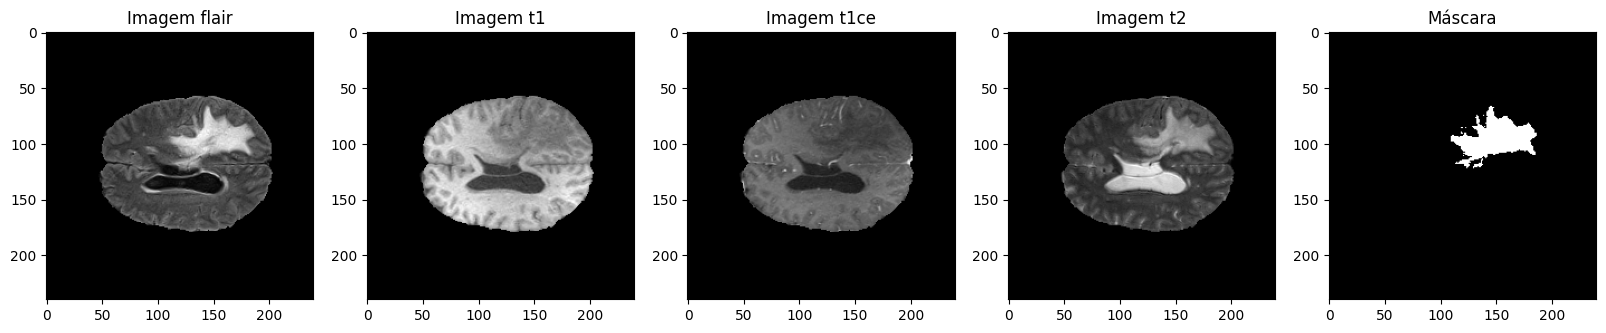

In [ ]:
#

TRAIN_DATASET_PATH2= f'{DATA_PATH}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_00{numcase}/BraTS20_Training_00{numcase}'
TRAIN_DATASET_PATH = f'{TRAIN_PATH}/'

test_image_flair=nib.load(TRAIN_DATASET_PATH2 + '_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH2 + '_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH2 + '_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH2 + '_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH2 + '_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25   # <<-----------   fatia escolhida manualmente para plotar
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Imagem flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Imagem t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Imagem t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Imagem t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w], cmap = 'gray')
ax5.set_title('Máscara')

In [ ]:
#len(test_image_flair)
(test_image_flair).shape
#tem 3 dimensões

(240, 240, 155)

Text(0.5, 1.0, 'Máscara')

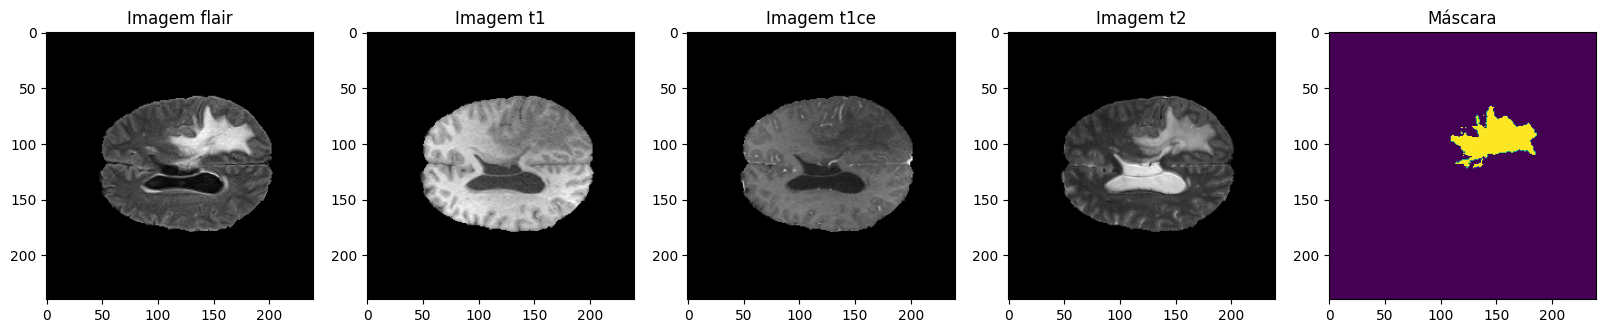

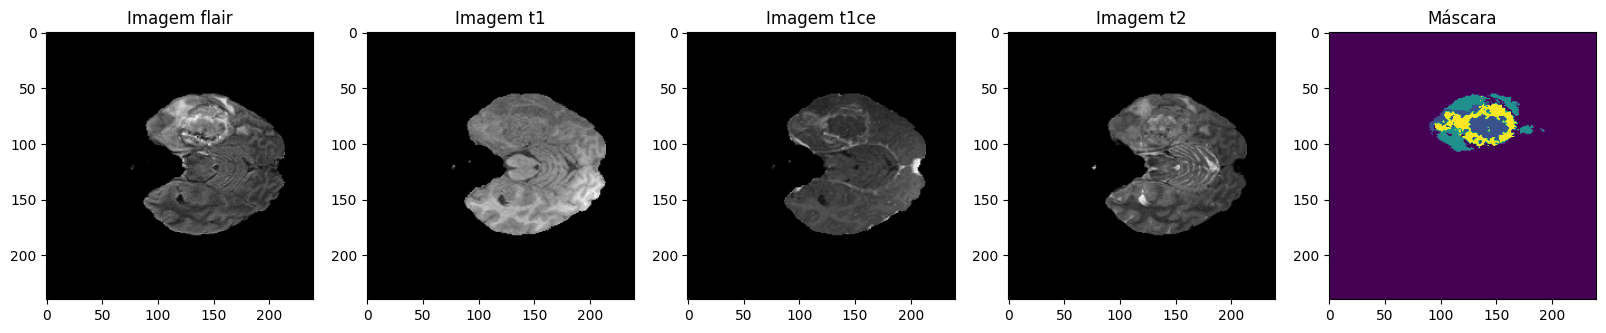

In [ ]:

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25 #fatia escolhida manualmente para plotar
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[1]//2-slice_w], cmap = 'gray')
ax1.set_title('Imagem flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[1]//2-slice_w], cmap = 'gray')
ax2.set_title('Imagem t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[1]//2-slice_w], cmap = 'gray')
ax3.set_title('Imagem t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[1]//2-slice_w], cmap = 'gray')
ax4.set_title('Imagem t2')
ax5.imshow(test_mask[:,:,test_mask.shape[1]//2-slice_w])
ax5.set_title('Máscara')

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[2]//2-slice_w], cmap = 'gray')
ax1.set_title('Imagem flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[2]//2-slice_w], cmap = 'gray')
ax2.set_title('Imagem t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[2]//2-slice_w], cmap = 'gray')
ax3.set_title('Imagem t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[2]//2-slice_w], cmap = 'gray')
ax4.set_title('Imagem t2')
ax5.imshow(test_mask[:,:,test_mask.shape[2]//2-slice_w])
ax5.set_title('Máscara')




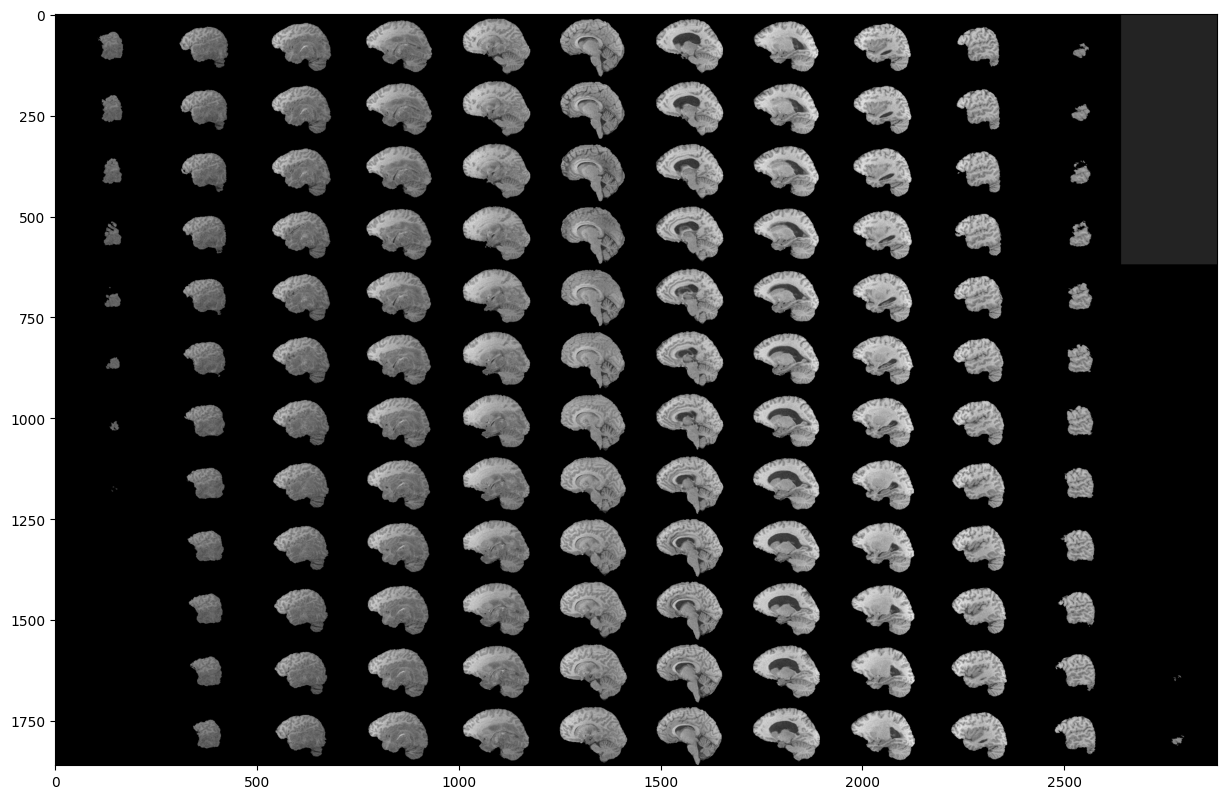

In [ ]:
# Pular 50 a -50 fatias
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

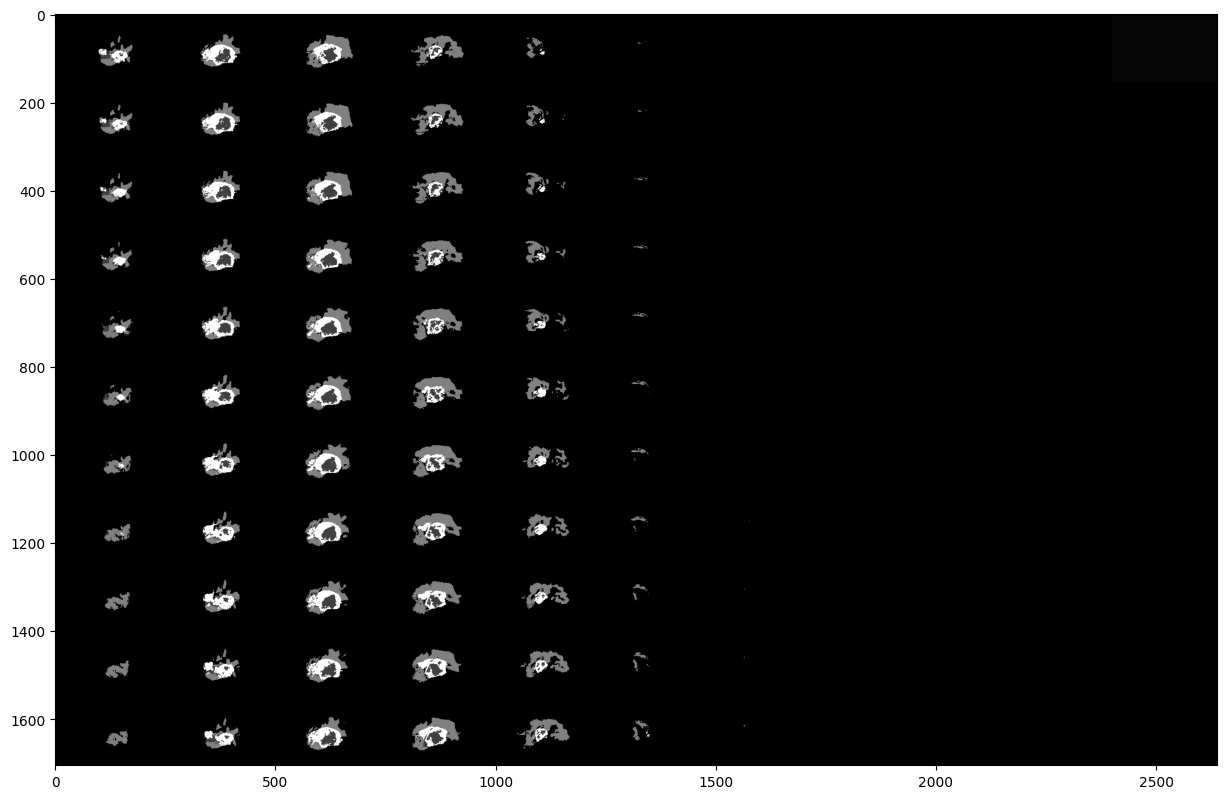

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

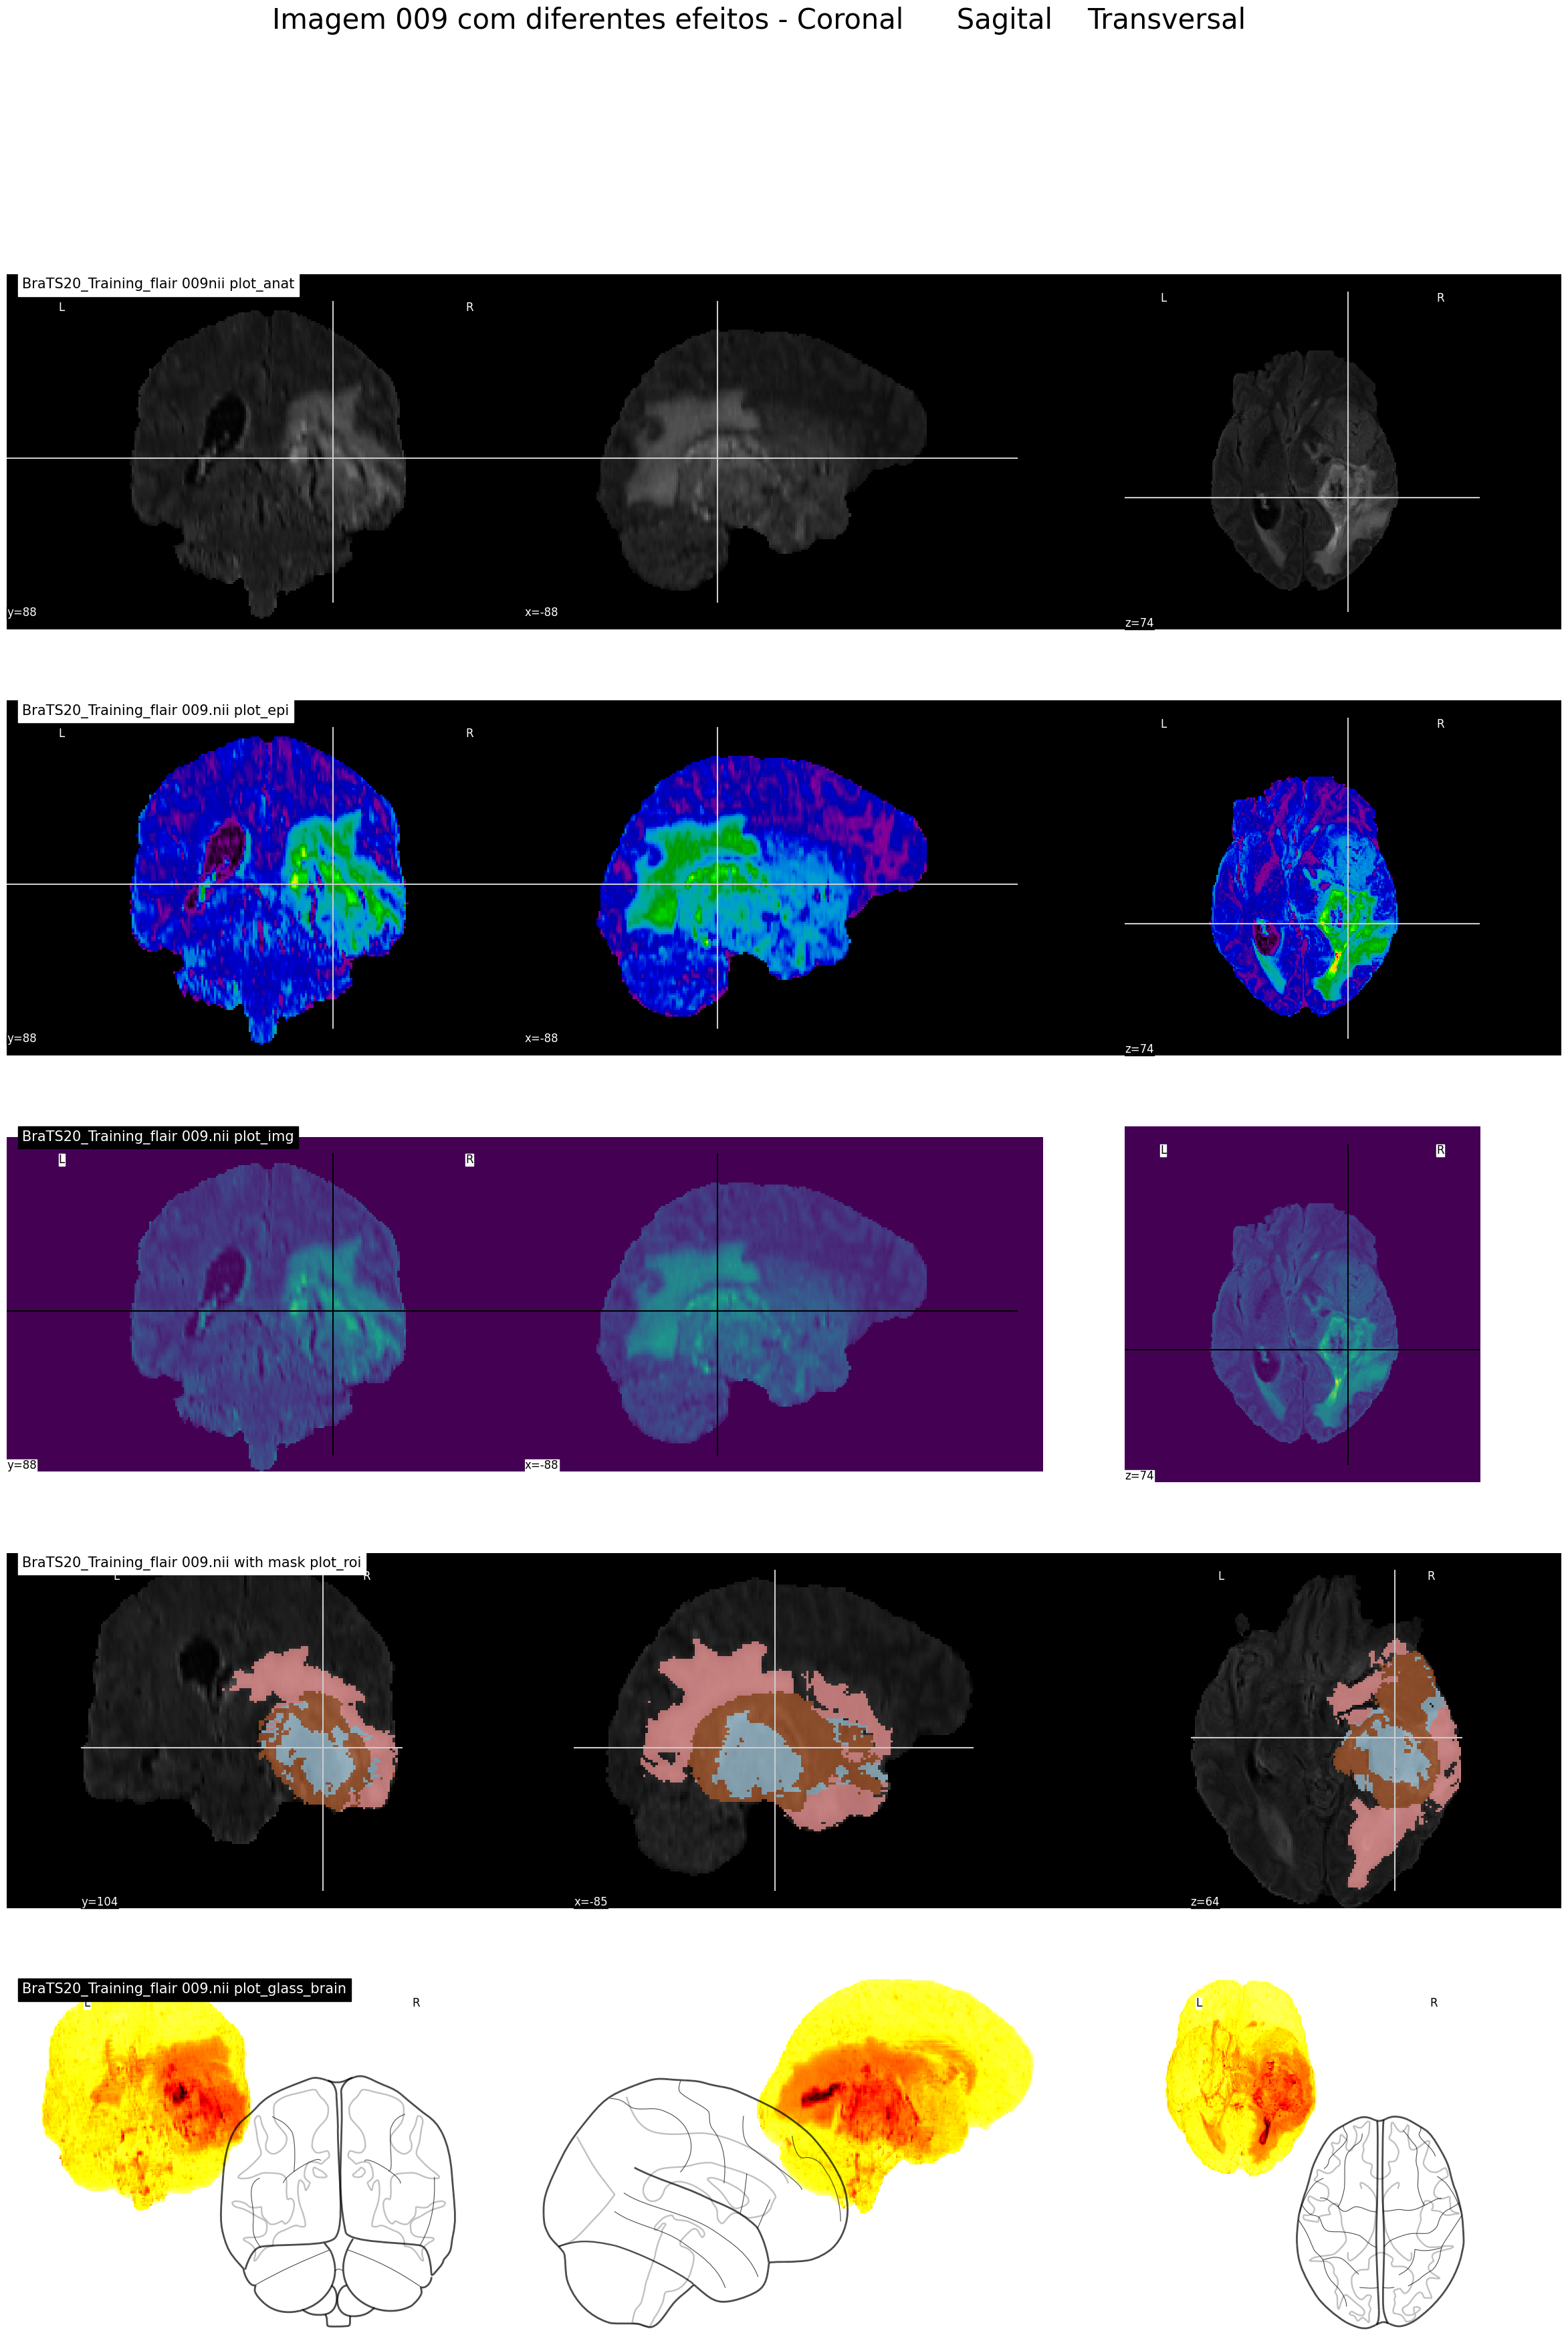

In [ ]:
# Trabalhando com a biblioteca nilearn

niimg = nl.image.load_img(TRAIN_DATASET_PATH2 + '_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH2 + '_seg.nii')

fig, axes = plt.subplots(nrows=5, figsize=(30, 40))
fig.suptitle('Imagem 00'+ str(numcase) +' com diferentes efeitos - Coronal      Sagital    Transversal', fontsize=30)


nlplt.plot_anat(niimg,
                title='BraTS20_Training_flair 00'+ str(numcase) +'nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_flair 00'+ str(numcase) +'.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_flair 00'+ str(numcase) +'.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS20_Training_flair 00'+ str(numcase) +'.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

nlplt.plot_glass_brain(niimg,
                title='BraTS20_Training_flair 00'+ str(numcase) +'.nii plot_glass_brain',
                axes=axes[4])

plt.show()

In [ ]:

def mse(y_true, y_pred):
    class_num = 4
    #mse_values = []  # Lista para armazenar os valores de MSE para cada classe
    for i in range(class_num):
        y_true_flat = K.flatten(y_true[:,:,:,i])
        y_pred_flat = K.flatten(y_pred[:,:,:,i])
        mse_class = mean_squared_error(y_true_flat, y_pred_flat)
        if i == 0:
          tmse_class = mse_class
        else:
          tmse_class = mse_class + mse_class
        #mse_values.append(mse_class)
    mse = tmse_class/class_num                  #K.mean(K.stack(mse_values))  # Agrupa os valores de MSE para cada classe e calcula a média
    return mse



def mae(y_true, y_pred):
    class_num = 4
    #mae_values = []  # Lista para armazenar os valores de MSE para cada classe
    for i in range(class_num):
        y_true_flat = K.flatten(y_true[:,:,:,i])
        y_pred_flat = K.flatten(y_pred[:,:,:,i])
        mae_class = mean_absolute_error(y_true_flat, y_pred_flat)
        if i == 0:
          tmae_class = mae_class
        else:
          tmae_class = mae_class + tmae_class
        #mae_values.append(mae_class)
    mae = tmae_class/class_num                            #K.mean(K.stack(mae_values))
    return mae



def soft_dice_loss6(y_true, y_pred, epsilon=1e-6):
    """Calculates the soft Dice loss."""
    class_num = 4
    dice_loss = 0
    for i in range(class_num):
        numerator = 2 * tf.reduce_sum(tf.abs(y_true[:,:,:,i] * y_pred[:,:,:,i])) + epsilon
        denominator = tf.reduce_sum(tf.square(y_true[:,:,:,i])) + tf.reduce_sum(tf.square(y_pred[:,:,:,i])) + epsilon
        class_dice_loss = 1 - (numerator / denominator)
        dice_loss += class_dice_loss
    return dice_loss / class_num


# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,1])) + tf.reduce_sum(tf.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,2])) + tf.reduce_sum(tf.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,3])) + tf.reduce_sum(tf.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
IMG_SIZE=128


In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss




def soft_dice_loss(y_true, y_pred, epsilon=0.00001):
    class_num = 4
    for i in range(class_num):
        intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,i] * y_pred[:,:,:,i]))
        denominador = (tf.reduce_sum(tf.square(y_true[:,:,:,i])) + tf.reduce_sum(tf.square(y_pred[:,:,:,i])) + epsilon)
    soft_dice_loss = 1 - (2. * intersection) / denominador   # total_loss #/ class_num
    return soft_dice_loss /369


In [ ]:
# ECC + SDL ------> ESTA É A PARTE DA PERDA PERSONALIZADA QUE É FUNDAMENTAL PARA O TREINAMENTO

class CustomCategoricalCrossentropy(tf.keras.losses.Loss):

    def __init__(self, label_smoothing=1e-6, class_weights=None, dice_weight=0.5, name='custom_categorical_crossentropy'):
        super(CustomCategoricalCrossentropy, self).__init__(name=name)
        self.label_smoothing = label_smoothing
        self.class_weights = class_weights
        self.dice_weight = dice_weight

    def call(self, y_true, y_pred):
        # Aplicar suavização de rótulo
        y_true = y_true * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

        # Calcular a entropia cruzada categórica
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Calcular a perda suave Dice
        intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
        union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))
        dice_coefficient = (2.0 * intersection + 1e-6) / (union + 1e-6)
        dice_loss = 1.0 - dice_coefficient

        # Combinar as perdas
        loss = cross_entropy + self.dice_weight * dice_loss

        # Aplicar ponderação de classes
        if self.class_weights is not None:
            class_weights = tf.cast(self.class_weights, dtype=tf.float32)
            loss = loss * class_weights

        # Retornar a perda combinada
        return loss

In [ ]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)



# ECC + SDL
#model.compile(loss= CustomCategoricalCrossentropy(label_smoothing= 1e-6), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), soft_dice_loss6, tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, tf.keras.metrics.CategoricalCrossentropy(label_smoothing=1e-6)] )

#  ECC
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), soft_dice_loss6, tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, tf.keras.metrics.CategoricalCrossentropy(label_smoothing=1e-6)])




Nesse trecho do código, você está criando uma rede neural U-Net, que é um tipo de rede neural utilizada para segmentação de imagens. A rede é composta por camadas de convolução e max-pooling, seguidas por uma parte "U" da rede que é composta por camadas de convolução e up-sampling. A rede é construída utilizando o framework Keras, que é uma biblioteca de código aberto para ciência de dados e aprendizado de máquina.
Nessa parte do código, você está criando uma instância de uma classe `tf.keras.Model` chamada `model`. Essa classe é responsável por definir e criar uma rede neural, que é treinada e testada em seguida.

Primeiro, você define a entrada da rede, que é um tensor de tamanho `(IMG_SIZE, IMG_SIZE, 2)`. Em seguida, você chama a função `build_unet`, que é responsável por definir a arquitetura da rede neural. Essa função recebe três argumentos: `input_layer`, `ker_init` e `dropout`.

Depois de definir a arquitetura da rede, você compila o modelo, especificando a função de perda, o otimizador e as métricas que serão usadas durante o treinamento. No caso, a função de perda é a `categorical_crossentropy`, o otimizador é o Adam com taxa de aprendizado de 0.001 e as métricas são a `accuracy`, `MeanIoU`, `soft_dice_loss`, `dice_coef`, `precision`, `sensitivity`, `specificity`, `dice_coef_necrotic`, `dice_coef_edema` e `dice_coef_enhancing`.

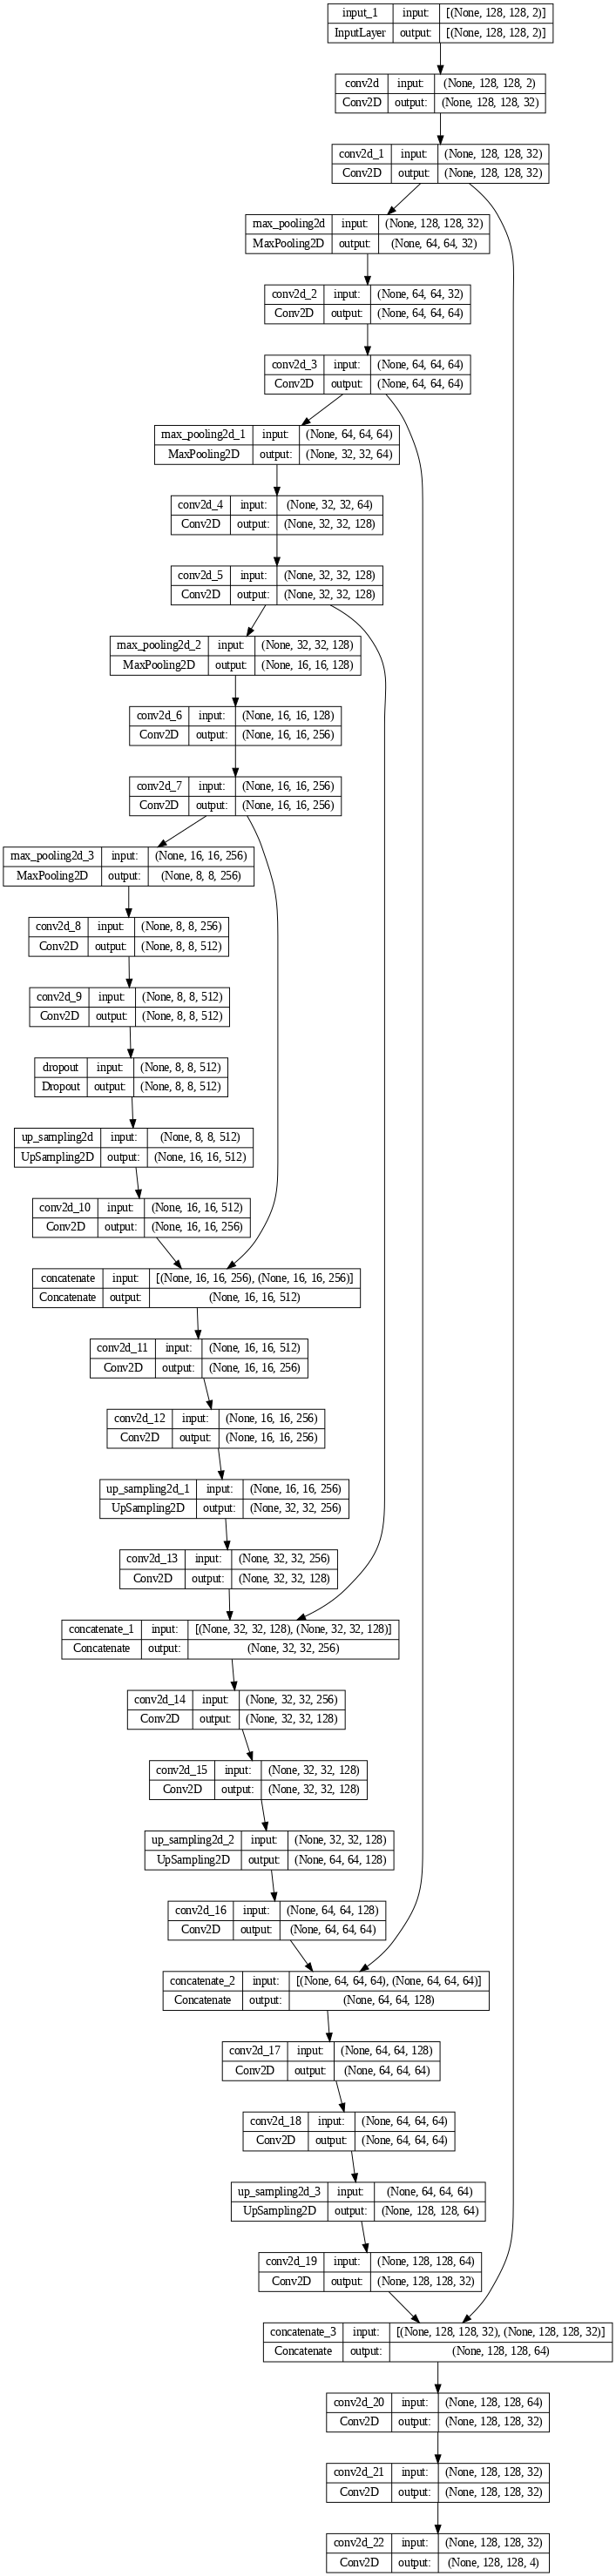

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
# preparar conjuntos de identificadores (IDs) para treinamento, validação e teste
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# arquivo BraTS20_Training_355 esta com problema, aqui vms remover
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:]) # extrai os IDs, que são as partes finais dos caminhos
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) #train_and_test_ids é dividido em train_test_ids e val_ids.
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) #train_ids é dividido em train_ids e test_ids.

In [ ]:
#Carregar todos os dados na memória não é uma boa ideia,
#pois os dados são grandes demais para caberem. Portanto, criaremos dataGenerators - carregaremos os dados dinamicamente

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y    # normalização é feita dividindo todas as imagens em X pelo valor máximo encontrado em X.

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

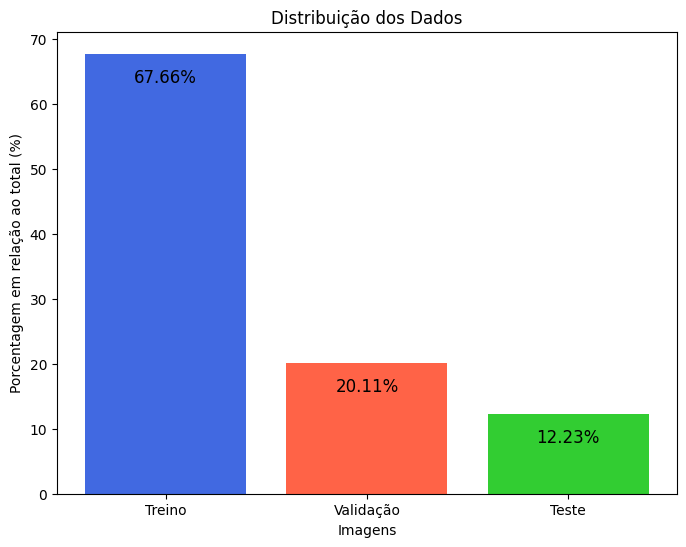

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dados de exemplo
categorias = ["Treino", "Validação", "Teste"]
valores = [len(train_ids), len(val_ids), len(test_ids)]

# Calcula o valor total
total = sum(valores)

# Calcula as porcentagens de cada categoria em relação ao total
porcentagens = [valor / total * 100 for valor in valores]

# Cores para cada categoria
cores = ['royalblue', 'tomato', 'limegreen']

# Inicializa o gráfico
plt.figure(figsize=(8, 6))

# Cria a barra empilhada
plt.bar(categorias, porcentagens, color=cores)

# Personaliza as barras
plt.xlabel('Imagens')
plt.ylabel('Porcentagem em relação ao total (%)')
plt.title('Distribuição dos Dados')

# Adiciona as porcentagens acima ou dentro das barras
for i, v in enumerate(porcentagens):
    if v < 5:  # Se a porcentagem for menor que 5%, coloca o texto dentro da barra
        plt.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=12)
    else:
        plt.text(i, v - 5, f'{v:.2f}%', ha='center', va='bottom', fontsize=12)

# Exibe o gráfico
plt.show()

Nessa parte do código, ele está criando um diretório para armazenar o log do treinamento do modelo. A função `makedirs` cria o diretório especificado em `log_folder`, caso ele não exista. Em seguida, você cria um arquivo CSV para registrar o progresso do treinamento, usando a classe `CSVLogger`.

Depois disso, ele define um conjunto de chamadas de retorno para o treinamento do modelo. O primeiro call back é `ReduceLROnPlateau`, que reduz a taxa de aprendizado em platôs de perda. O segundo callback é `csv_logger`, que registra o progresso do treinamento em um arquivo CSV. Esses callbacks são adicionados ao modelo usando a função `model.fit`.

In [ ]:

log_folder = '/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/'  # Substitua pelo caminho real da sua pasta

# Verifica se o diretório existe, se não, cria
os.makedirs(log_folder, exist_ok=True)

log_file_path = os.path.join(log_folder, 'trainingcopy51.log')

csv_logger = CSVLogger(log_file_path, separator=',', append=False)



callbacks = [

      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,   #val_loss     #'soft_dice_loss'
                              patience=2, min_lr=0.000001, verbose=1),

        csv_logger
    ]

# Nova seção

No código, a função de perda que é utilizada durante o treinamento do modelo é "categorical\_crossentropy". No entanto, também são registrados outros valores de perda, como "soft\_dice\_loss", "dice\_coef", "precision", "sensitivity", "specificity", "dice\_coef\_necrotic", "dice\_coef\_edema" e "dice\_coef\_enhancing". Esses valores são registrados em um arquivo CSV durante o treinamento usando o callbacks "csv\_logger". Portanto, a função de perda real usada no treinamento é a "categorical\_crossentropy", mas outros valores de perda são registrados para análise posterior.

In [ ]:
K.clear_session()
#sess = tf.compat.v1.Session()
# rode esse comando toda vez que precisar parar o treinamento no meio, ele limpa as variáveis para não criar versões v2 v3...

In [ ]:
import datetime

In [ ]:
history =  model.fit(training_generator,
                     epochs= 40,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
model.save_weights("/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/model_x80_dcs65weightscopy51.h5")
model.save("/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/model_x80_dcs65copy51.h5")


Epoch 1/40
249/249 [==============================] - 1353s 5s/step - loss: 0.1192 - accuracy: 0.9798 - mean_io_u: 0.5246 - soft_dice_loss6: 0.6969 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0223 - precision: 0.9774 - sensitivity: 0.9686 - specificity: 0.9947 - dice_coef_necrotic: 0.0533 - dice_coef_edema: 0.1253 - dice_coef_enhancing: 0.0485 - categorical_crossentropy: 0.1192 - val_loss: 0.0710 - val_accuracy: 0.9826 - val_mean_io_u: 0.4315 - val_soft_dice_loss6: 0.6871 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0150 - val_precision: 0.9825 - val_sensitivity: 0.9825 - val_specificity: 0.9942 - val_dice_coef_necrotic: 0.0426 - val_dice_coef_edema: 0.1333 - val_dice_coef_enhancing: 0.0834 - val_categorical_crossentropy: 0.0710 - lr: 0.0010
Epoch 2/40
249/249 [==============================] - 262s 1s/step - loss: 0.0712 - accuracy: 0.9837 - mean_io_u: 0.6273 - soft_dice_loss6: 0.6802 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0155 - precision: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Modelo Treinado de melhor desempenho com a utilização da Perda Entropia Cruzada Categórica (ECC)**

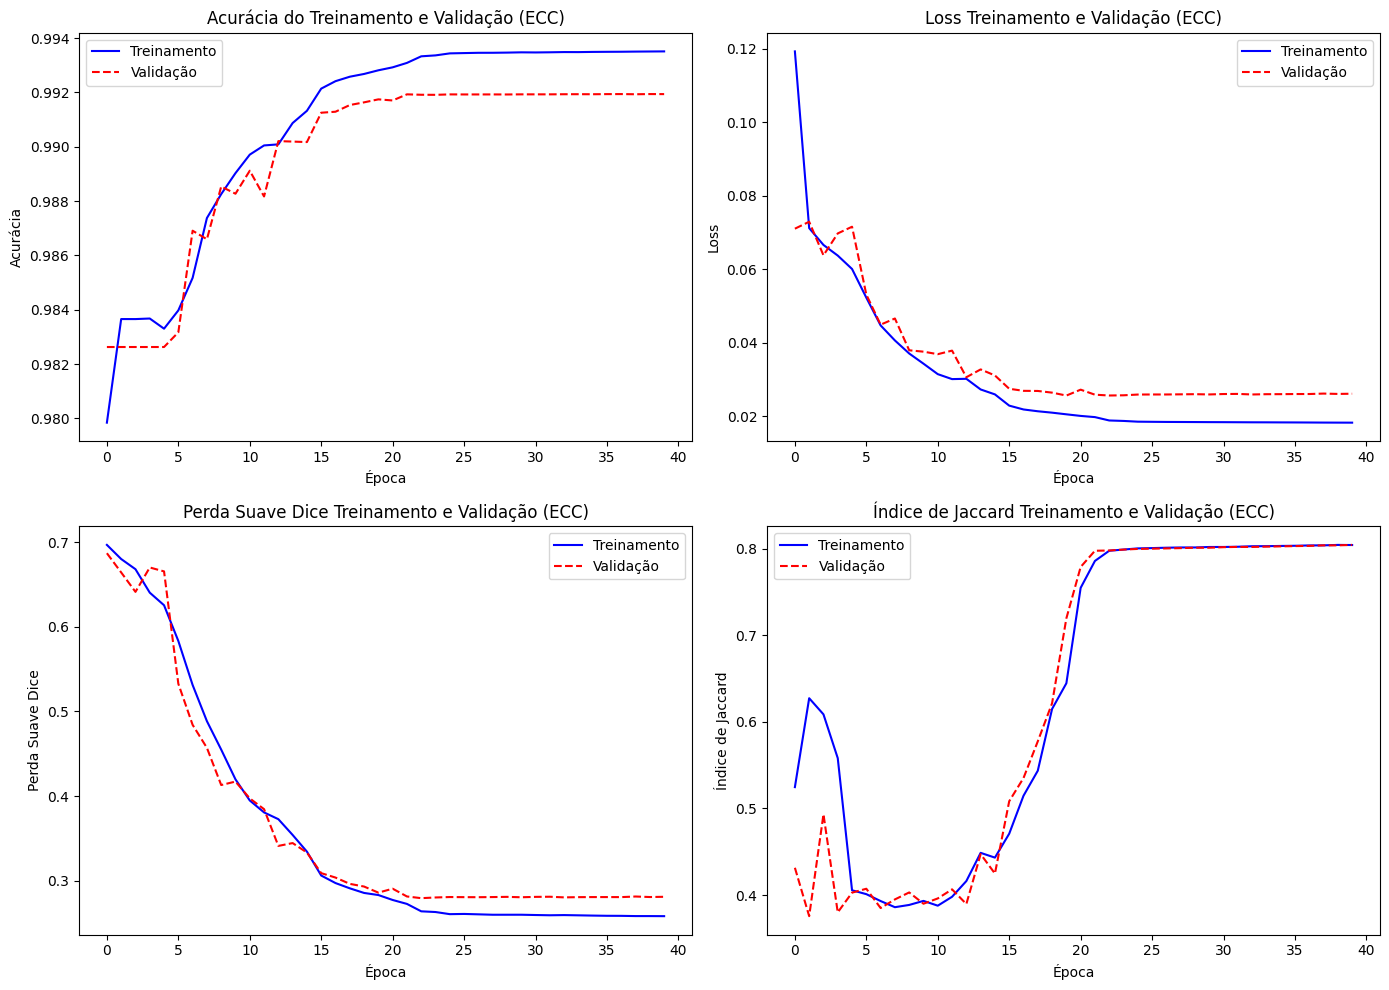

In [ ]:

model = keras.models.load_model('/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/model_x80_dcs65copy51.h5',

                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "soft_dice_loss": soft_dice_loss,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/trainingcopy51.log', sep=',', engine='python')


hist=history


epoch = range(len(hist))

train_acc = hist['accuracy']
val_acc = hist['val_accuracy']

train_loss = hist['loss']
val_loss = hist['val_loss']

train_dice = hist['soft_dice_loss6']
val_dice = hist['val_soft_dice_loss6']

train_mean_iou = hist['mean_io_u']
val_mean_iou = hist['val_mean_io_u']



# Crie uma figura com subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Accuracy
ax[0, 0].plot(epoch, train_acc, 'b', label='Treinamento')
ax[0, 0].plot(epoch, val_acc, 'r--', label='Validação')
ax[0, 0].set_xlabel('Época')
ax[0, 0].set_ylabel('Acurácia')
ax[0, 0].set_title('Acurácia do Treinamento e Validação (ECC)')
ax[0, 0].legend()

# Gráfico 2: Loss
ax[0, 1].plot(epoch, train_loss, 'b', label='Treinamento')
ax[0, 1].plot(epoch, val_loss, 'r--', label='Validação')
ax[0, 1].set_xlabel('Época')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_title('Loss Treinamento e Validação (ECC)')
ax[0, 1].legend()

# Gráfico 3: Dice Coefficient
ax[1, 0].plot(epoch, train_dice, 'b', label='Treinamento')
ax[1, 0].plot(epoch, val_dice, 'r--', label='Validação')
ax[1, 0].set_xlabel('Época')
ax[1, 0].set_ylabel('Perda Suave Dice')
ax[1, 0].set_title('Perda Suave Dice Treinamento e Validação (ECC)')
ax[1, 0].legend()

# Gráfico 4: Mean IOU  -  Índice de Sobreposição da União (Intersection over Union)
ax[1, 1].plot(epoch, train_mean_iou, 'b', label='Treinamento')
ax[1, 1].plot(epoch, val_mean_iou, 'r--', label='Validação')
ax[1, 1].set_xlabel('Época')
ax[1, 1].set_ylabel('Índice de Jaccard')
ax[1, 1].set_title('Índice de Jaccard Treinamento e Validação (ECC)')
ax[1, 1].legend()



# Ajuste o layout
plt.tight_layout()

# Exibir a figura
plt.show()

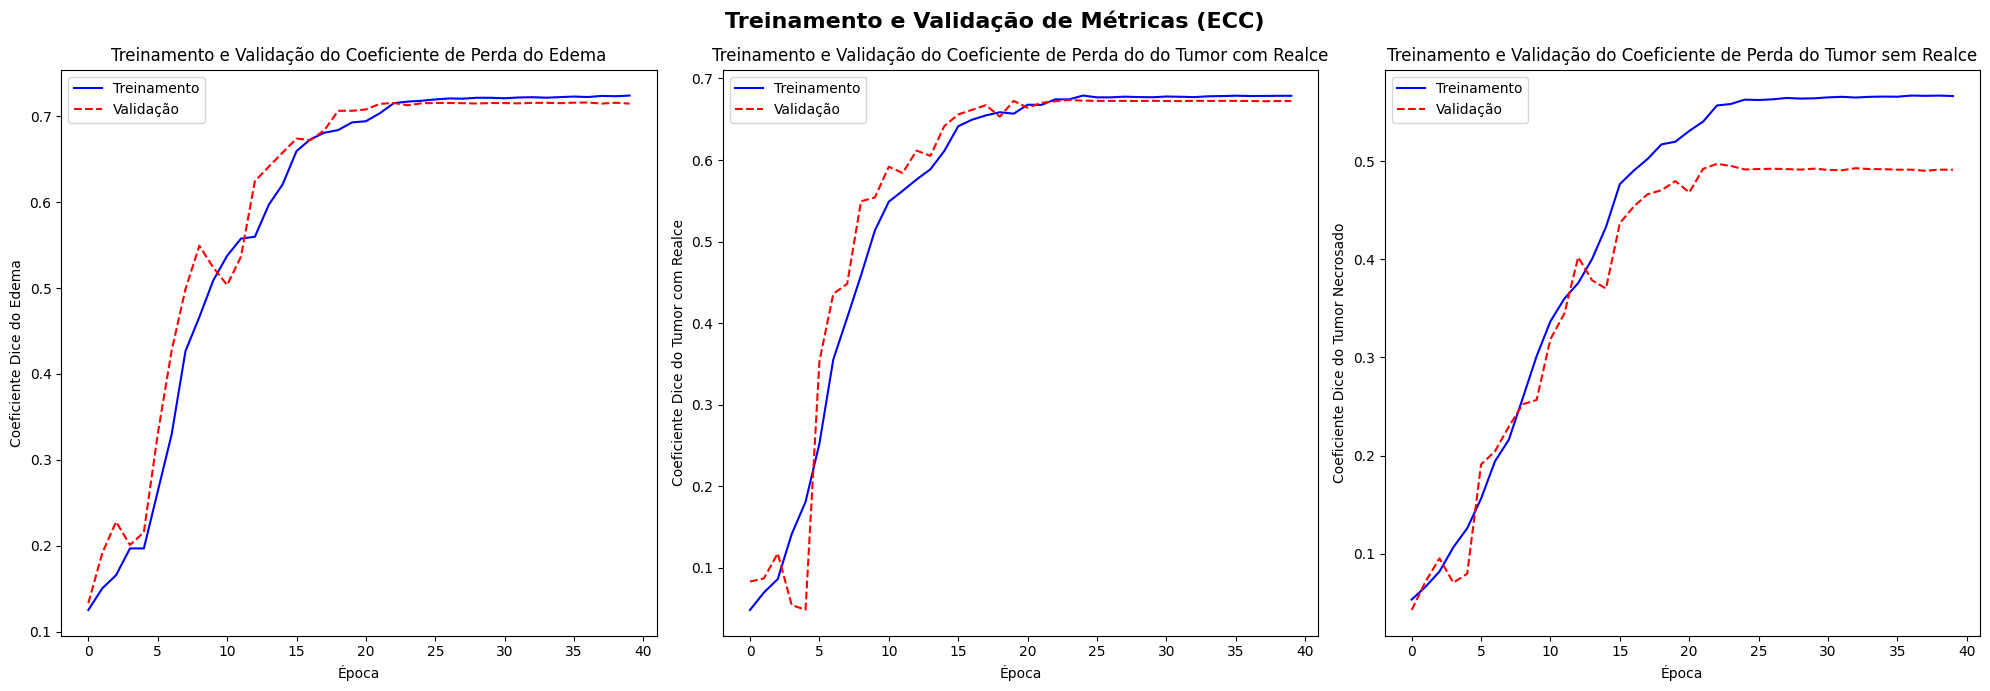

In [ ]:


train_dice_coef_edema = hist['dice_coef_edema']
val_dice_coef_edema = hist['val_dice_coef_edema']

train_dice_coef_enhancing = hist['dice_coef_enhancing']
val_dice_coef_enhancing = hist['val_dice_coef_enhancing']

train_dice_coef_necrotic = hist['dice_coef_necrotic']
val_dice_coef_necrotic = hist['val_dice_coef_necrotic']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 7))

# Gráfico 1: Accuracy
ax1[0].plot(epoch, train_dice_coef_edema, 'b', label='Treinamento')
ax1[0].plot(epoch, val_dice_coef_edema, 'r--', label='Validação')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Coeficiente Dice do Edema')
ax1[0].set_title('Treinamento e Validação do Coeficiente de Perda do Edema')
ax1[0].legend()

# Gráfico 2: Loss
ax1[1].plot(epoch, train_dice_coef_enhancing, 'b', label='Treinamento')
ax1[1].plot(epoch, val_dice_coef_enhancing, 'r--', label='Validação')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Coeficiente Dice do Tumor com Realce')
ax1[1].set_title('Treinamento e Validação do Coeficiente de Perda do do Tumor com Realce')
ax1[1].legend()

# Gráfico 3: Dice Coefficient
ax1[2].plot(epoch, train_dice_coef_necrotic, 'b', label='Treinamento')
ax1[2].plot(epoch, val_dice_coef_necrotic, 'r--', label='Validação')
ax1[2].set_xlabel('Época')
ax1[2].set_ylabel('Coeficiente Dice do Tumor Necrosado')
ax1[2].set_title('Treinamento e Validação do Coeficiente de Perda do Tumor sem Realce')
ax1[2].legend()

# Adicione um título geral
plt.suptitle('Treinamento e Validação de Métricas (ECC)', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

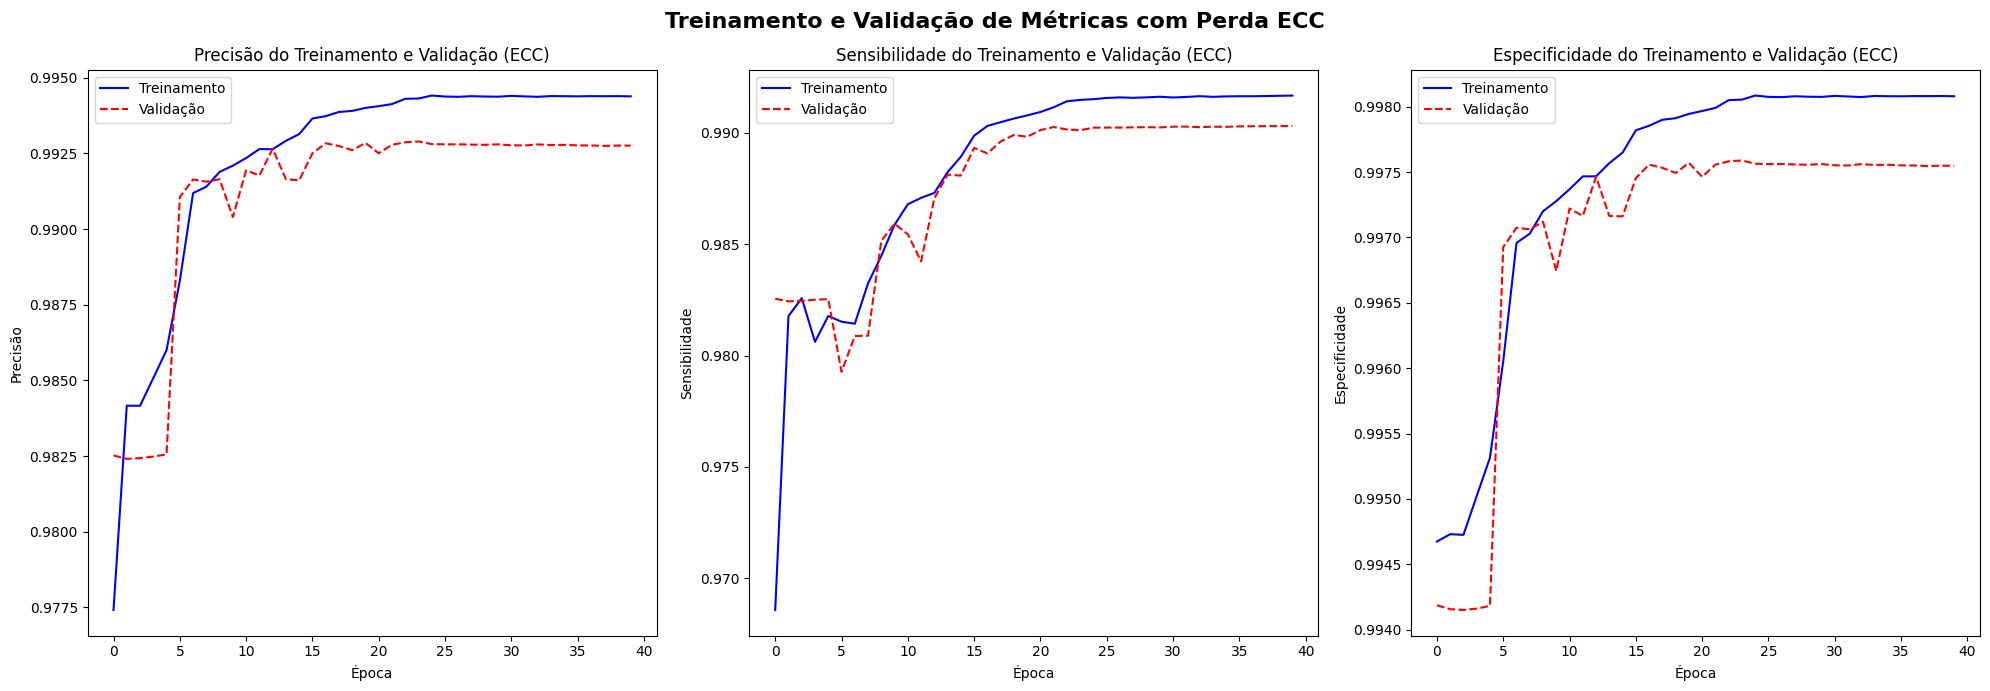

In [ ]:
# PRECISÃO, ESPECIFICIDADE E SENSIBILIDADE

train_precision = hist['precision']
val_precision = hist['val_precision']

train_sensitivity = hist['sensitivity']
val_sensitivity = hist['val_sensitivity']

train_specificity = hist['specificity']
val_specificity = hist['val_specificity']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 7))

# Gráfico 1: Precisão
ax1[0].plot(epoch, train_precision, 'b', label='Treinamento')
ax1[0].plot(epoch, val_precision, 'r--', label='Validação')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Precisão')
ax1[0].set_title('Precisão do Treinamento e Validação (ECC)')
ax1[0].legend()

# Gráfico 2: Sensibilidade
ax1[1].plot(epoch, train_sensitivity, 'b', label='Treinamento')
ax1[1].plot(epoch, val_sensitivity, 'r--', label='Validação')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Sensibilidade')
ax1[1].set_title('Sensibilidade do Treinamento e Validação (ECC)')
ax1[1].legend()

# Gráfico 3: Especificidade
ax1[2].plot(epoch, train_specificity, 'b', label='Treinamento')
ax1[2].plot(epoch, val_specificity, 'r--', label='Validação')
ax1[2].set_xlabel('Época')
ax1[2].set_ylabel('Especificidade')
ax1[2].set_title('Especificidade do Treinamento e Validação (ECC)')
ax1[2].legend()

# Adicione um título geral
plt.suptitle('Treinamento e Validação de Métricas com Perda ECC', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

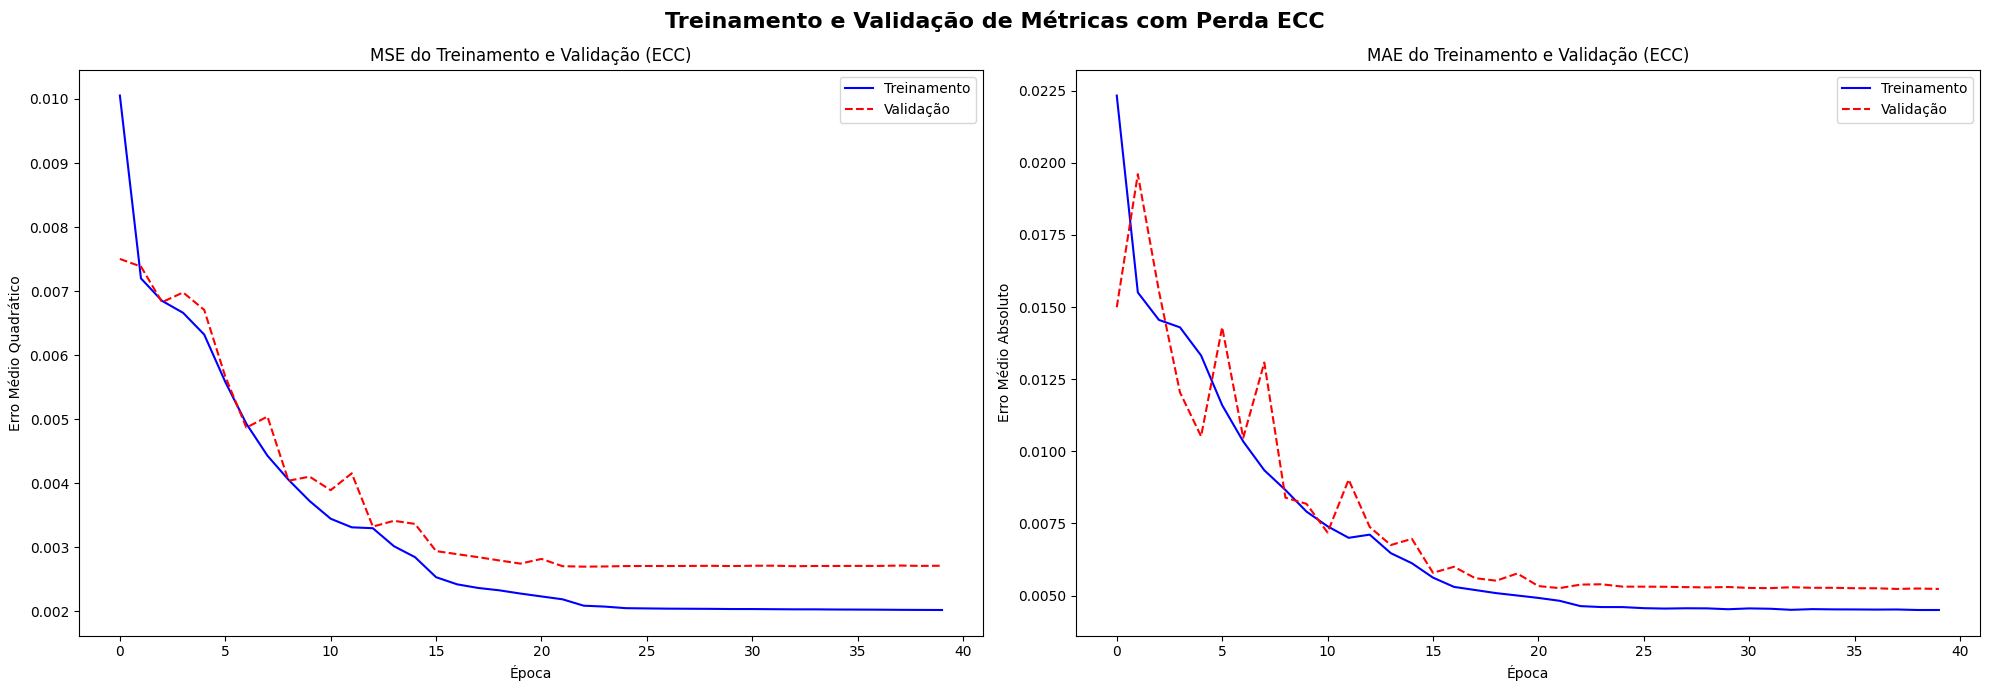

In [ ]:
# ERRO QUADRATICO E ABSOLUTO

train_mean_squared_error = hist['mean_squared_error']
val_mean_squared_error = hist['val_mean_squared_error']

train_mean_absolute_error = hist['mean_absolute_error']
val_mean_absolute_error = hist['val_mean_absolute_error']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, train_mean_squared_error, 'b', label='Treinamento')
ax1[0].plot(epoch, val_mean_squared_error, 'r--', label='Validação')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Erro Médio Quadrático')
ax1[0].set_title('MSE do Treinamento e Validação (ECC)')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, train_mean_absolute_error, 'b', label='Treinamento')
ax1[1].plot(epoch, val_mean_absolute_error, 'r--', label='Validação')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Erro Médio Absoluto')
ax1[1].set_title('MAE do Treinamento e Validação (ECC)')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Treinamento e Validação de Métricas com Perda ECC', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

## **Modelo Treinado de melhor desempenho com a utilização da perda combinada de Entropia Cruzada Categórica + Perda Suave Dice (ECC + SDL)**

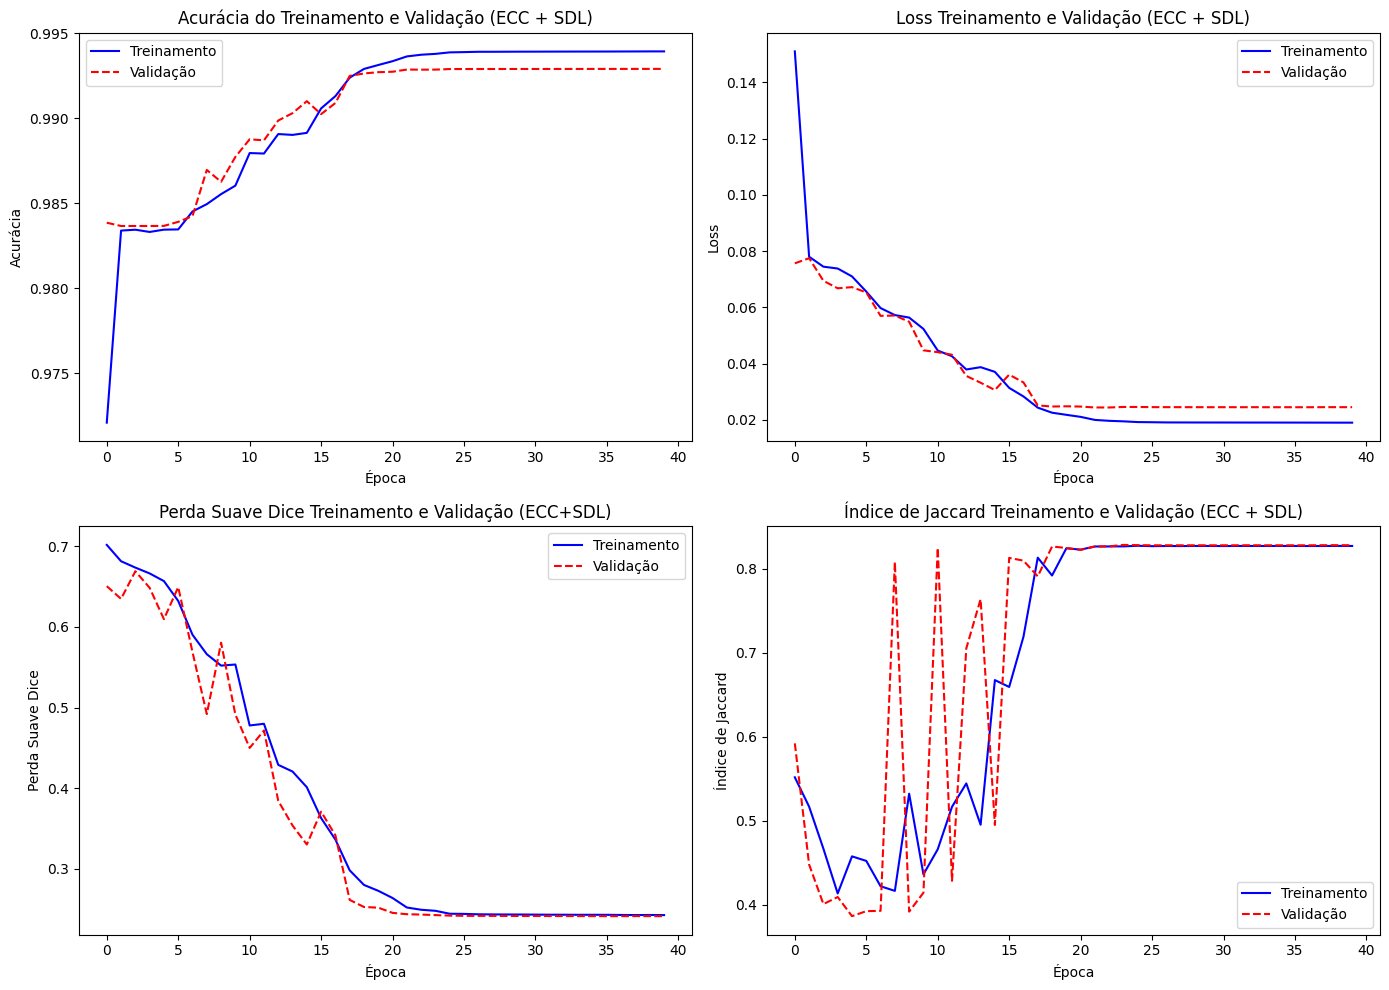

In [ ]:
############ load trained model ################
model = keras.models.load_model('/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/model_x80_dcs65copy42.h5',

                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "soft_dice_loss": soft_dice_loss,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/trainingcopy42outro7.log', sep=',', engine='python')


hist=history



epoch = range(len(hist))

train_acc = hist['accuracy']
val_acc = hist['val_accuracy']

train_loss = hist['loss']
val_loss = hist['val_loss']

train_dice = hist['soft_dice_loss6']
val_dice = hist['val_soft_dice_loss6']

train_mean_iou = hist['mean_io_u']
val_mean_iou = hist['val_mean_io_u']



# Crie uma figura com subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Accuracy
ax[0, 0].plot(epoch, train_acc, 'b', label='Treinamento')
ax[0, 0].plot(epoch, val_acc, 'r--', label='Validação')
ax[0, 0].set_xlabel('Época')
ax[0, 0].set_ylabel('Acurácia')
ax[0, 0].set_title('Acurácia do Treinamento e Validação (ECC + SDL)')
ax[0, 0].legend()

# Gráfico 2: Loss
ax[0, 1].plot(epoch, train_loss, 'b', label='Treinamento')
ax[0, 1].plot(epoch, val_loss, 'r--', label='Validação')
ax[0, 1].set_xlabel('Época')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_title('Loss Treinamento e Validação (ECC + SDL)')
ax[0, 1].legend()

# Gráfico 3: Dice Coefficient
ax[1, 0].plot(epoch, train_dice, 'b', label='Treinamento')
ax[1, 0].plot(epoch, val_dice, 'r--', label='Validação')
ax[1, 0].set_xlabel('Época')
ax[1, 0].set_ylabel('Perda Suave Dice')
ax[1, 0].set_title('Perda Suave Dice Treinamento e Validação (ECC+SDL)')
ax[1, 0].legend()

# Gráfico 4: Mean IOU  -  Índice de Sobreposição da União (Intersection over Union)
ax[1, 1].plot(epoch, train_mean_iou, 'b', label='Treinamento')
ax[1, 1].plot(epoch, val_mean_iou, 'r--', label='Validação')
ax[1, 1].set_xlabel('Época')
ax[1, 1].set_ylabel('Índice de Jaccard')
ax[1, 1].set_title('Índice de Jaccard Treinamento e Validação (ECC + SDL)')
ax[1, 1].legend()



# Ajuste o layout
plt.tight_layout()

# Exibir a figura
plt.show()

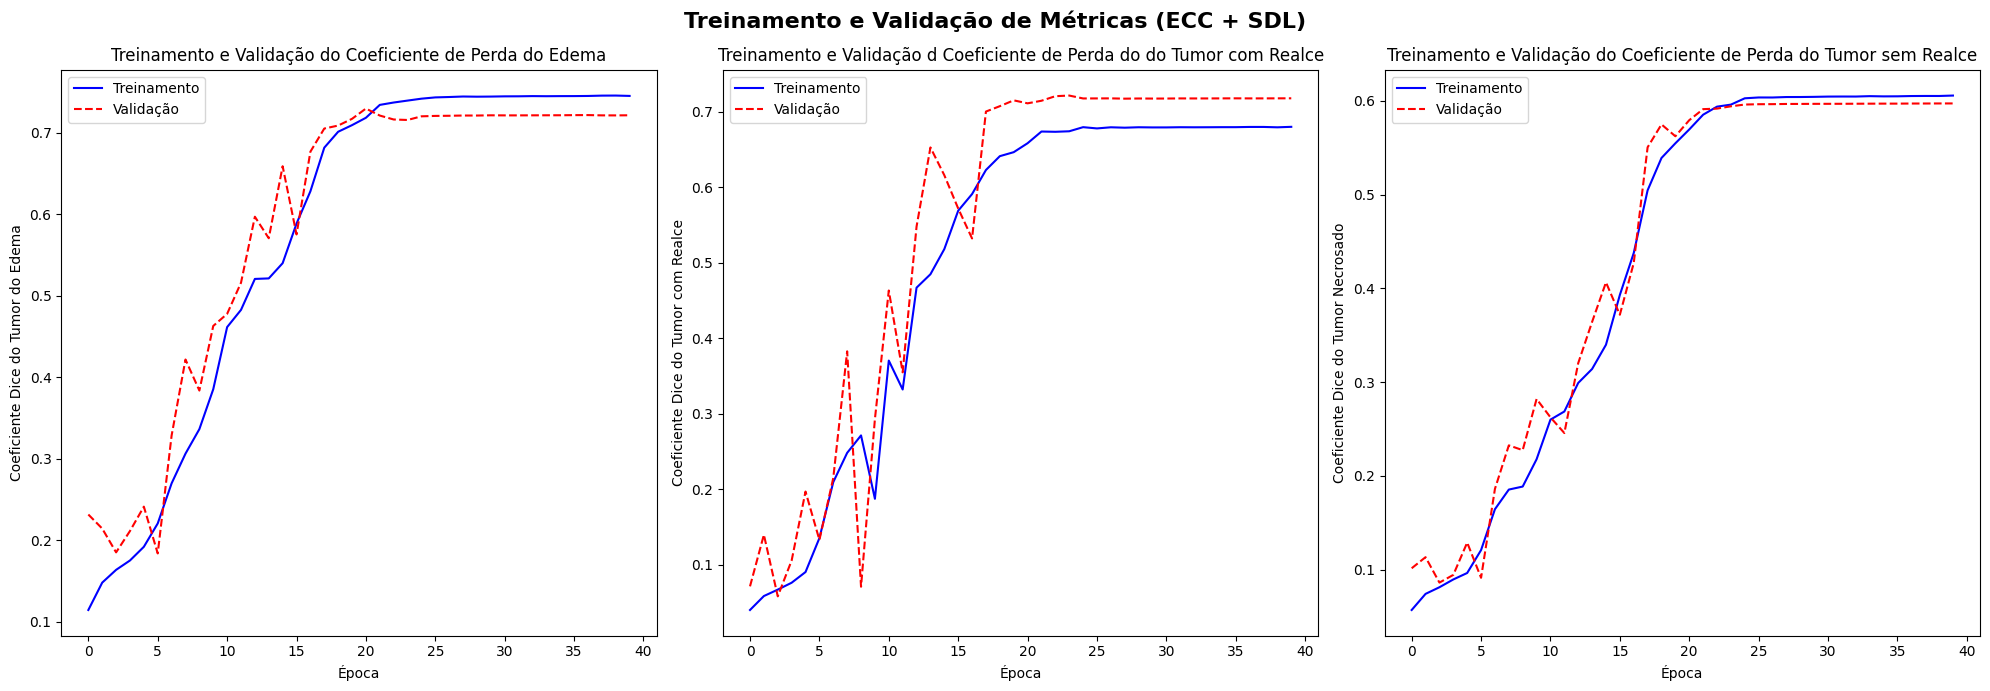

In [ ]:



train_dice_coef_edema = hist['dice_coef_edema']
val_dice_coef_edema = hist['val_dice_coef_edema']

train_dice_coef_enhancing = hist['dice_coef_enhancing']
val_dice_coef_enhancing = hist['val_dice_coef_enhancing']

train_dice_coef_necrotic = hist['dice_coef_necrotic']
val_dice_coef_necrotic = hist['val_dice_coef_necrotic']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 7))

# Gráfico 1: Accuracy
ax1[0].plot(epoch, train_dice_coef_edema, 'b', label='Treinamento')
ax1[0].plot(epoch, val_dice_coef_edema, 'r--', label='Validação')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Coeficiente Dice do Tumor do Edema')
ax1[0].set_title('Treinamento e Validação do Coeficiente de Perda do Edema')
ax1[0].legend()

# Gráfico 2: Loss
ax1[1].plot(epoch, train_dice_coef_enhancing, 'b', label='Treinamento')
ax1[1].plot(epoch, val_dice_coef_enhancing, 'r--', label='Validação')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Coeficiente Dice do Tumor com Realce')
ax1[1].set_title('Treinamento e Validação d Coeficiente de Perda do do Tumor com Realce')
ax1[1].legend()

# Gráfico 3: Dice Coefficient
ax1[2].plot(epoch, train_dice_coef_necrotic, 'b', label='Treinamento')
ax1[2].plot(epoch, val_dice_coef_necrotic, 'r--', label='Validação')
ax1[2].set_xlabel('Época')
ax1[2].set_ylabel('Coeficiente Dice do Tumor Necrosado')
ax1[2].set_title('Treinamento e Validação do Coeficiente de Perda do Tumor sem Realce')
ax1[2].legend()

# Adicione um título geral
plt.suptitle('Treinamento e Validação de Métricas (ECC + SDL)', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

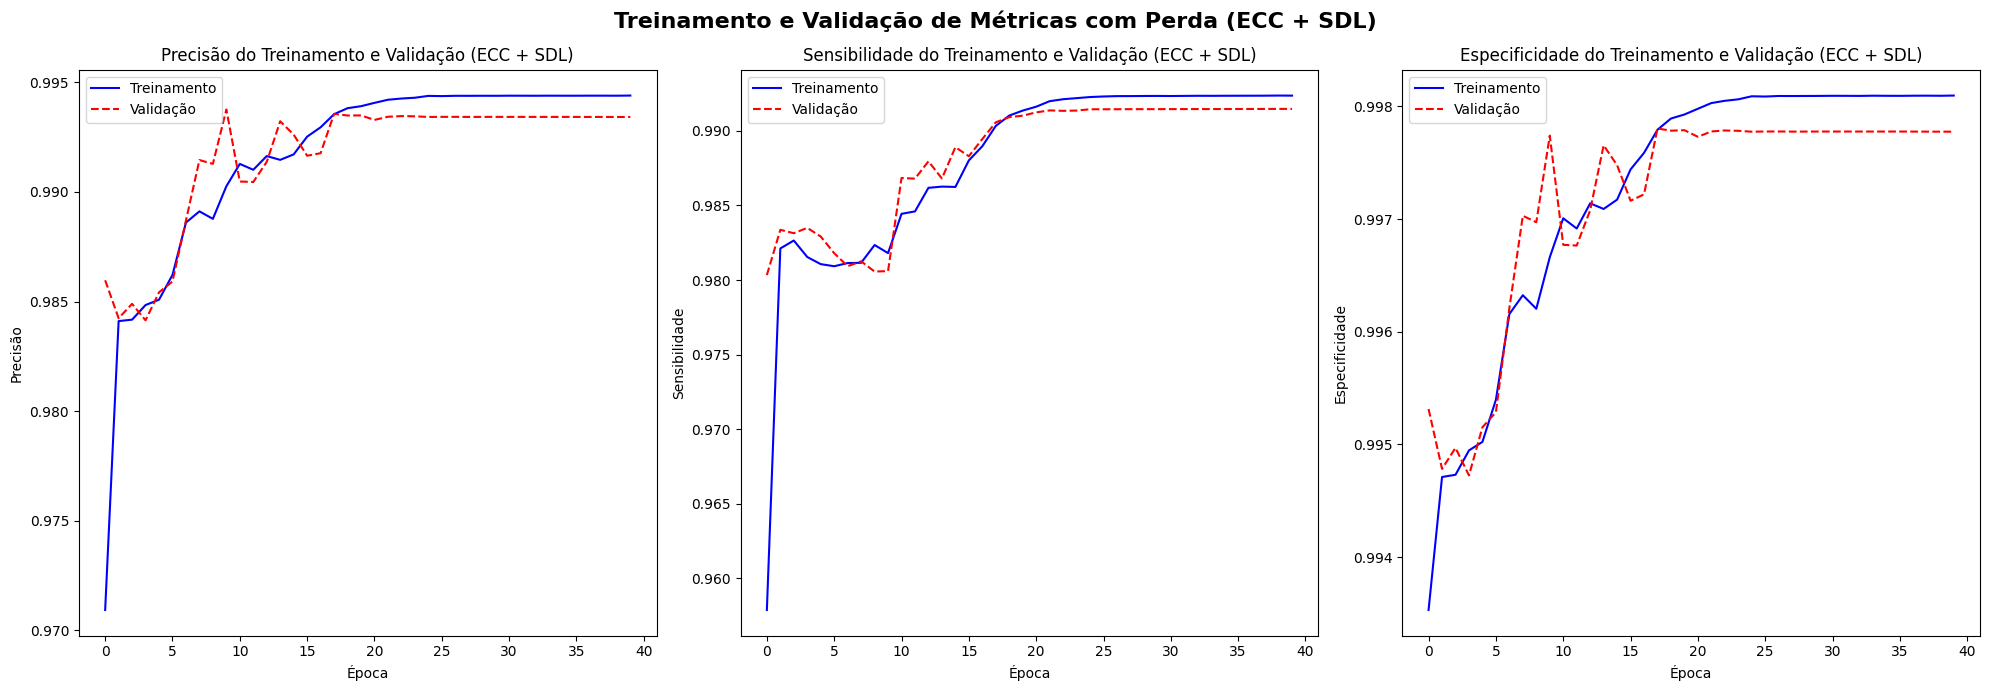

In [ ]:
# PRECISÃO, ESPECIFICIDADE E SENSIBILIDADE

train_precision = hist['precision']
val_precision = hist['val_precision']

train_sensitivity = hist['sensitivity']
val_sensitivity = hist['val_sensitivity']

train_specificity = hist['specificity']
val_specificity = hist['val_specificity']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 7))

# Gráfico 1: Precisão
ax1[0].plot(epoch, train_precision, 'b', label='Treinamento')
ax1[0].plot(epoch, val_precision, 'r--', label='Validação')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Precisão')
ax1[0].set_title('Precisão do Treinamento e Validação (ECC + SDL)')
ax1[0].legend()

# Gráfico 2: Sensibilidade
ax1[1].plot(epoch, train_sensitivity, 'b', label='Treinamento')
ax1[1].plot(epoch, val_sensitivity, 'r--', label='Validação')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Sensibilidade')
ax1[1].set_title('Sensibilidade do Treinamento e Validação (ECC + SDL)')
ax1[1].legend()

# Gráfico 3: Especificidade
ax1[2].plot(epoch, train_specificity, 'b', label='Treinamento')
ax1[2].plot(epoch, val_specificity, 'r--', label='Validação')
ax1[2].set_xlabel('Época')
ax1[2].set_ylabel('Especificidade')
ax1[2].set_title('Especificidade do Treinamento e Validação (ECC + SDL)')
ax1[2].legend()

# Adicione um título geral
plt.suptitle('Treinamento e Validação de Métricas com Perda (ECC + SDL)', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

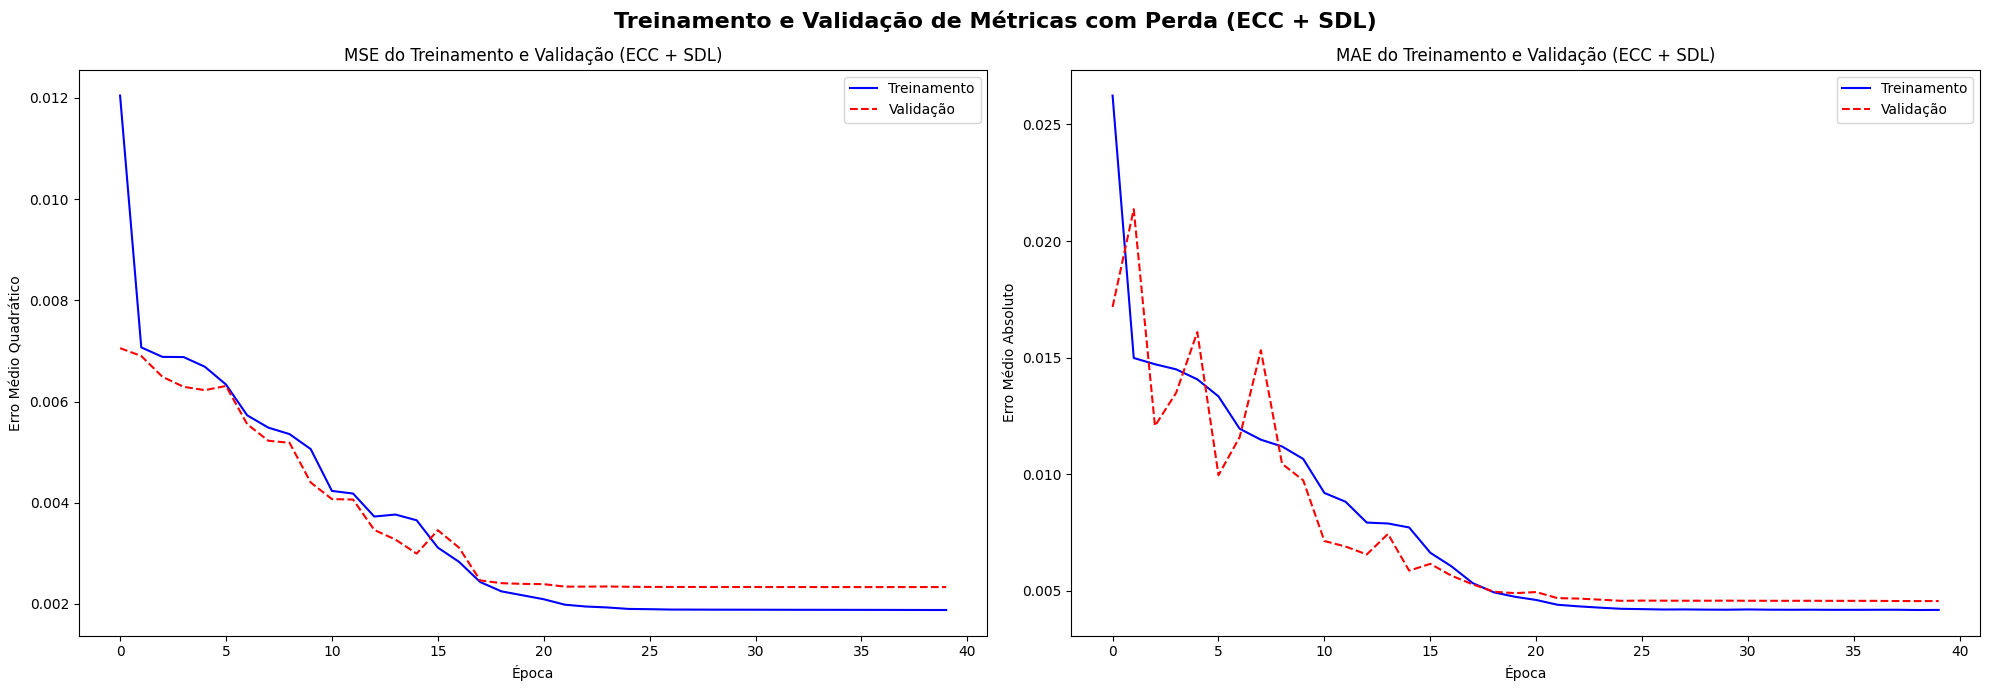

In [ ]:
# ERRO QUADRATICO E ABSOLUTO

train_mean_squared_error = hist['mean_squared_error']
val_mean_squared_error = hist['val_mean_squared_error']

train_mean_absolute_error = hist['mean_absolute_error']
val_mean_absolute_error = hist['val_mean_absolute_error']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, train_mean_squared_error, 'b', label='Treinamento')
ax1[0].plot(epoch, val_mean_squared_error, 'r--', label='Validação')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Erro Médio Quadrático')
ax1[0].set_title('MSE do Treinamento e Validação (ECC + SDL)')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, train_mean_absolute_error, 'b', label='Treinamento')
ax1[1].plot(epoch, val_mean_absolute_error, 'r--', label='Validação')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Erro Médio Absoluto')
ax1[1].set_title('MAE do Treinamento e Validação (ECC + SDL)')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Treinamento e Validação de Métricas com Perda (ECC + SDL)', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

In [ ]:
#Endereço das imagens /content/drive/MyDrive/IRM/Task01_BrainTumour/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData  BraTS20_Validation_001
#DATA_PATH = '/content/drive/MyDrive/IRM/Task01_BrainTumour/archive'
#VALID_PATH = f'{DATA_PATH}/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

#Numero da imagem que será estudada

#numcase = 6

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))#

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');#
    seg=nib.load(vol_path).get_fdata() #


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))#

    #model.evaluate(x=X,y=y, callbacks= callbacks)#
    return model.predict(X/np.max(X), verbose=1)

#cmap="viridis", color=fluorescent_green_rgb

fluorescent_green_rgb = (0 / 255, 255 / 255, 0 / 255)
def showPredictsById(case, start_slice = 60):
    path = f"{TRAIN_PATH}/BraTS20_Training_{case}"
    #/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]


    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(2,3, figsize = (15, 10))

    for i in range(2): # for each image, add brain background
      for j in range(3):
        axarr[i,j].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0,0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0,0].title.set_text(' Imagem Original Flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[0,1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[0,1].title.set_text('Ground truth')
    axarr[0,2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[0,2].title.set_text('all classes')
    axarr[1,0].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[1,0].title.set_text(f'{SEGMENT_CLASSES[1]} previsto')
    axarr[1,1].imshow(edema[start_slice,:,:], cmap='magma', interpolation='none', alpha=0.3)       #OrRd OrangeRed
    axarr[1,1].title.set_text(f'{SEGMENT_CLASSES[2]} previsto')
    axarr[1,2].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[1,2].title.set_text(f'{SEGMENT_CLASSES[3]} previsto')
    plt.show()


#"model.compile(optimizer='adam', loss='mse')"


# **Predição com Perda ECC**

4/4 [==============================] - 1s 317ms/step


<Figure size 1800x5000 with 0 Axes>

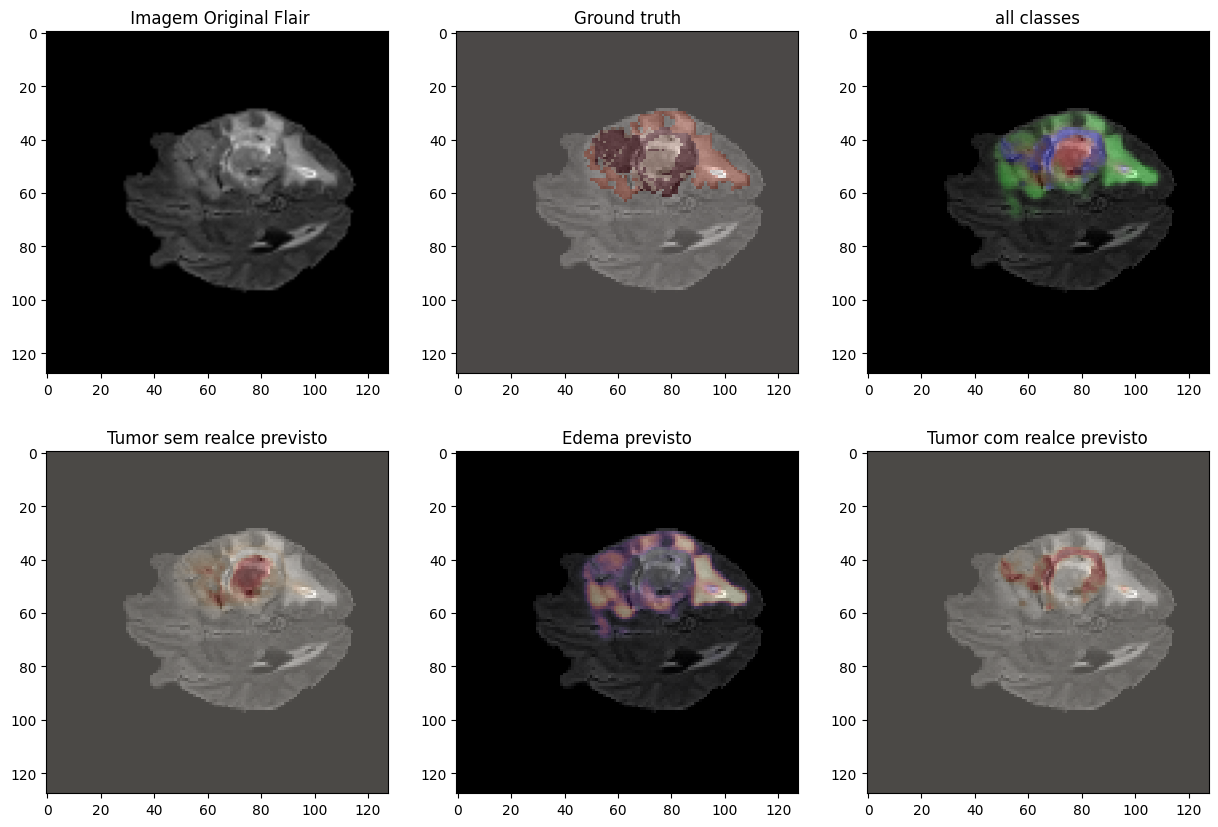

4/4 [==============================] - 3s 834ms/step


<Figure size 1800x5000 with 0 Axes>

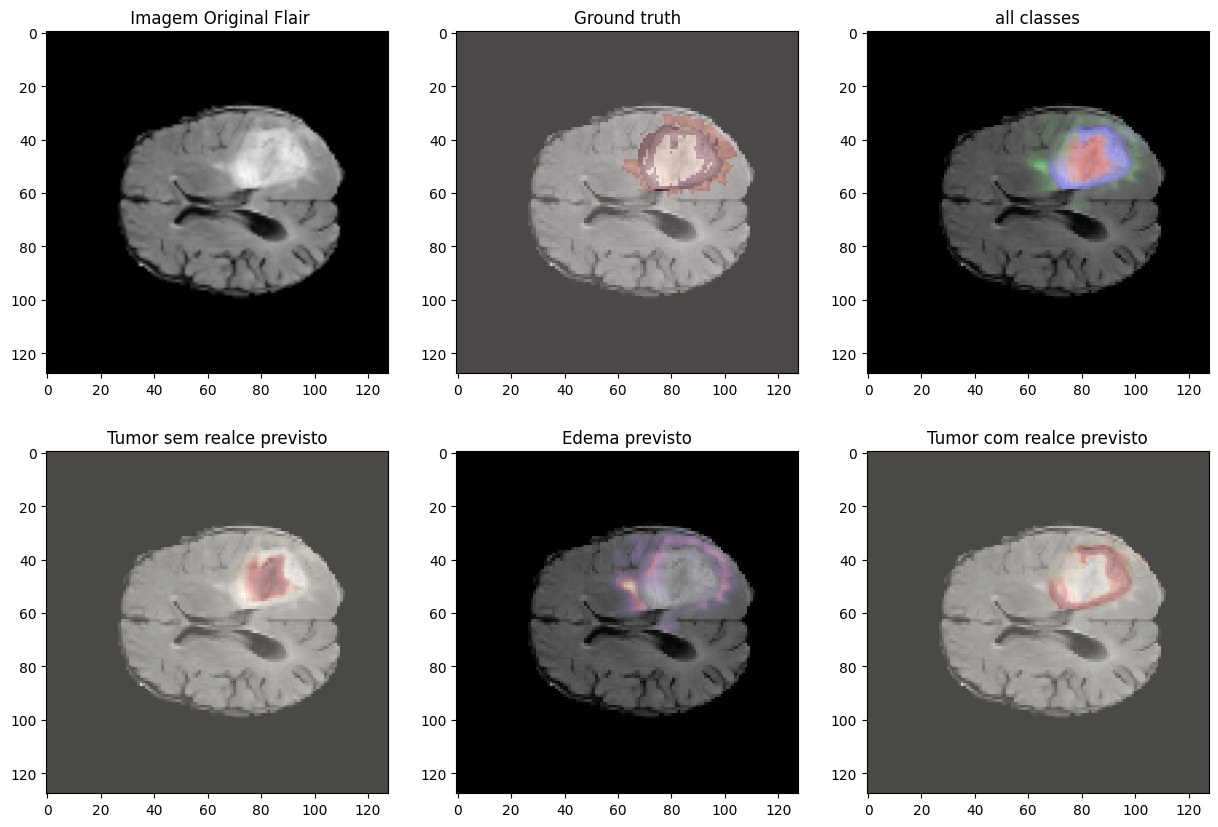

4/4 [==============================] - 1s 456ms/step


<Figure size 1800x5000 with 0 Axes>

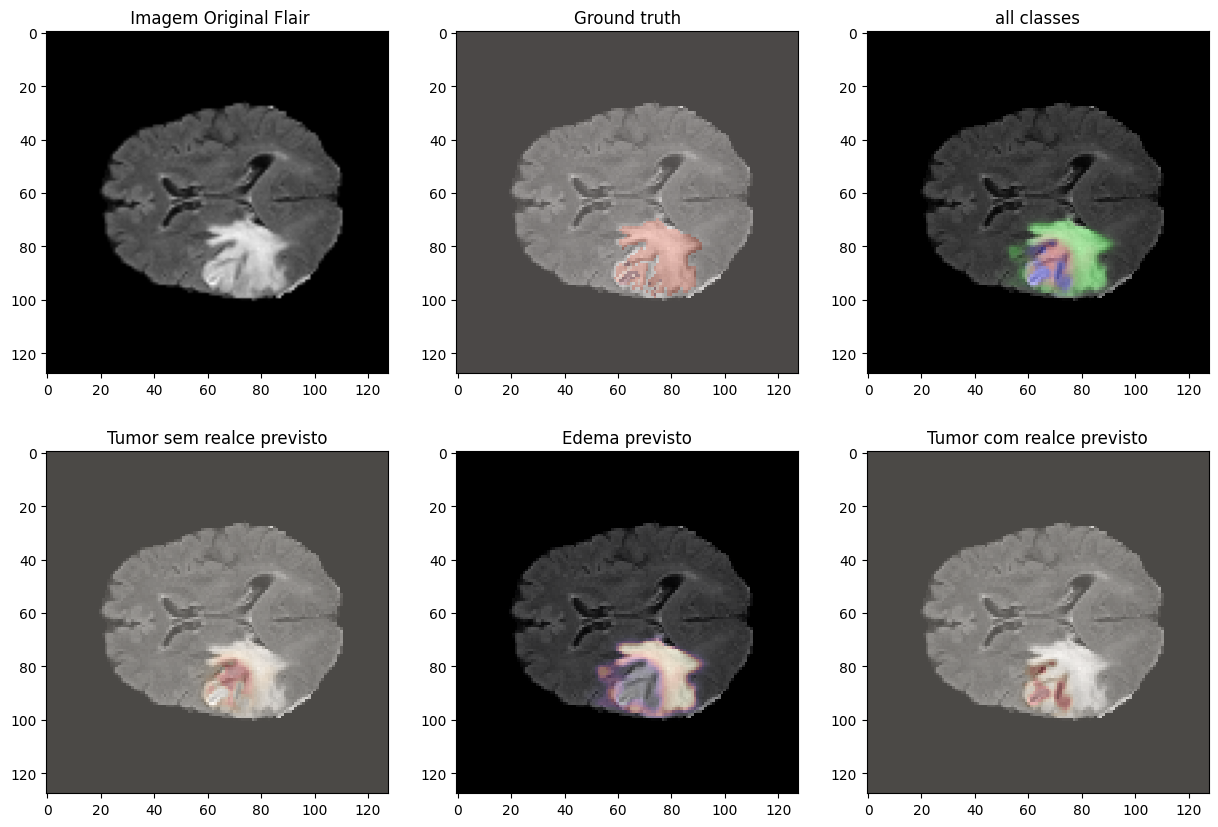

4/4 [==============================] - 0s 64ms/step


<Figure size 1800x5000 with 0 Axes>

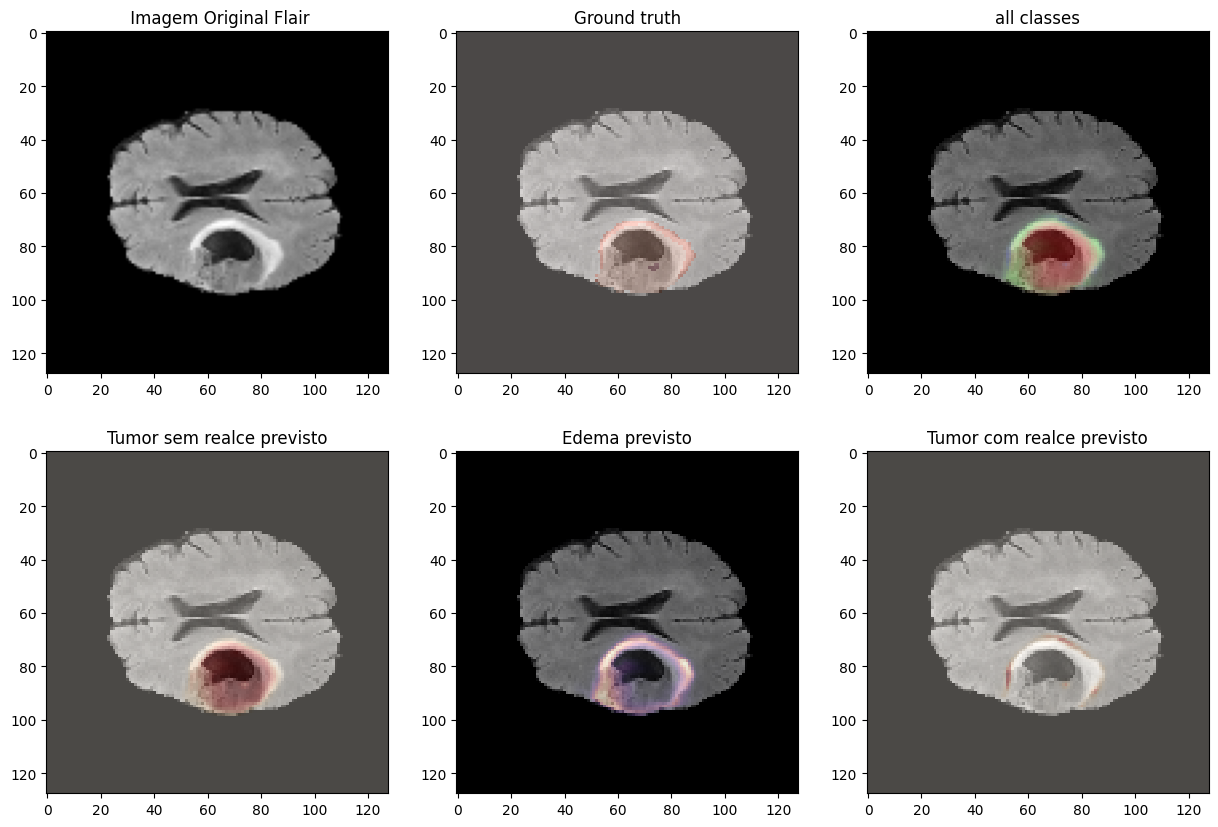

4/4 [==============================] - 0s 64ms/step


<Figure size 1800x5000 with 0 Axes>

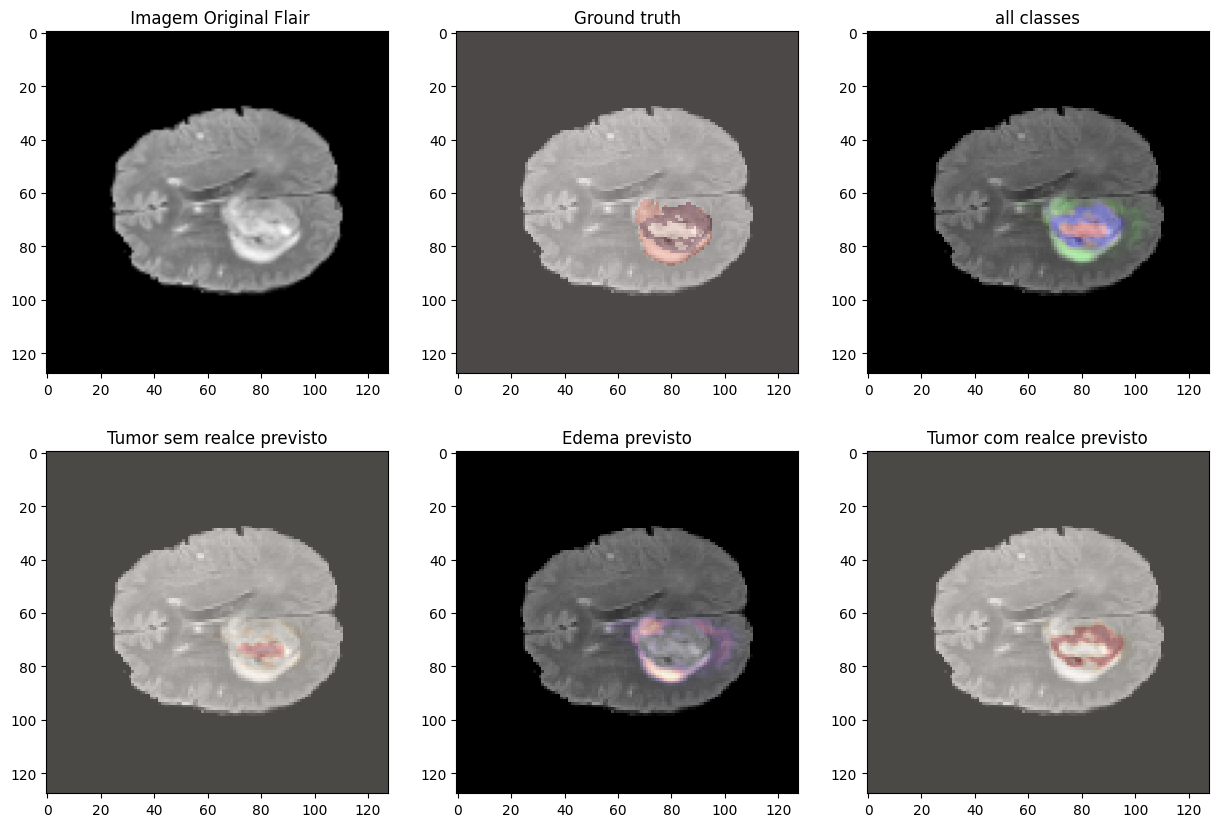

4/4 [==============================] - 1s 456ms/step


<Figure size 1800x5000 with 0 Axes>

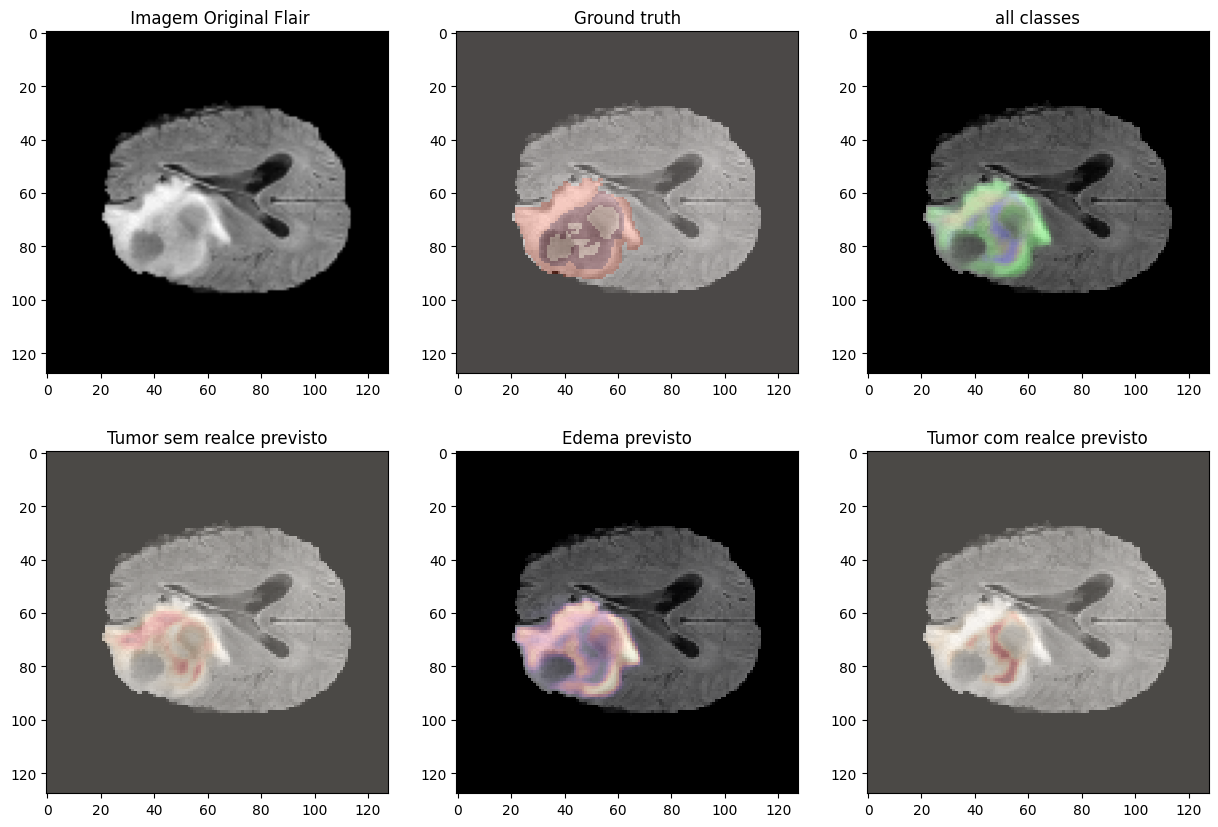

4/4 [==============================] - 0s 63ms/step


<Figure size 1800x5000 with 0 Axes>

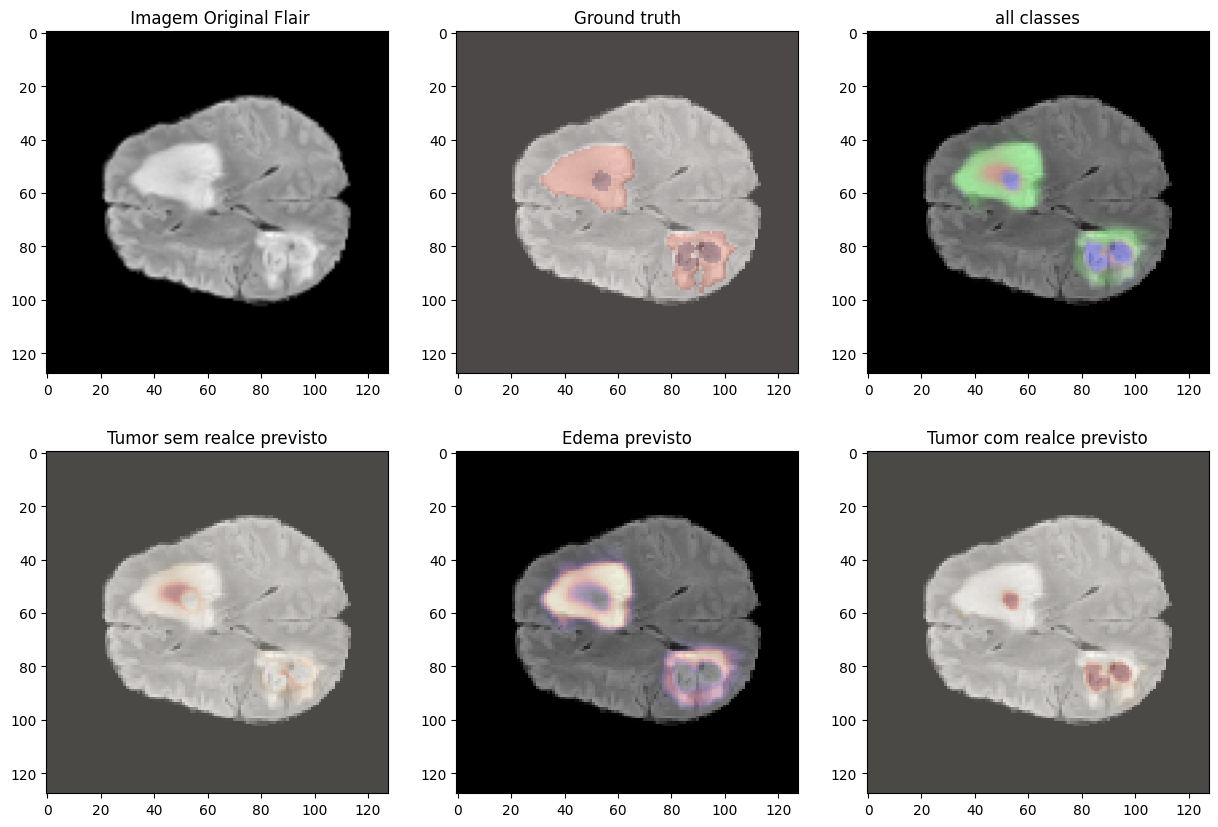

4/4 [==============================] - 1s 474ms/step


<Figure size 1800x5000 with 0 Axes>

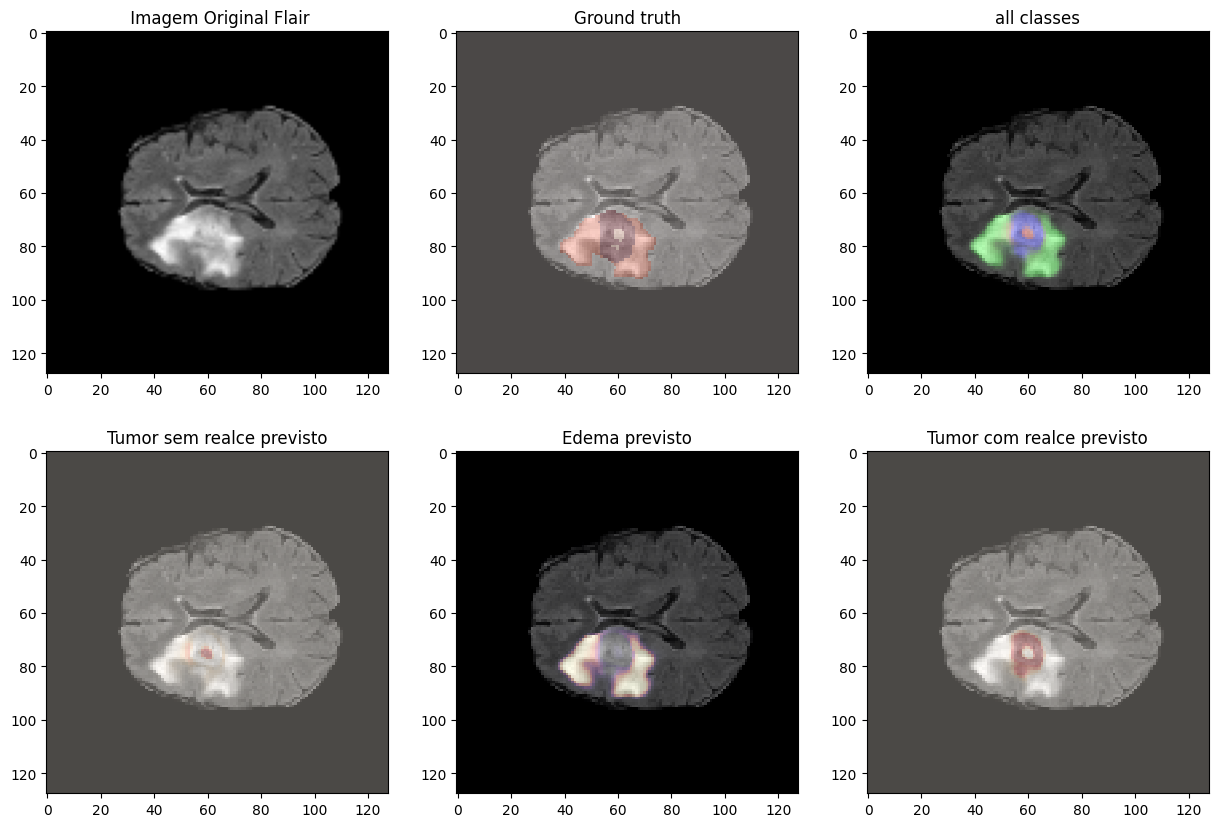

In [ ]:
showPredictsById("00"+str(numcase),46)
showPredictsById(case=test_ids[10][-3:])
showPredictsById(case=test_ids[12][-3:])
showPredictsById(case=test_ids[22][-3:])
showPredictsById(case=test_ids[14][-3:])
showPredictsById(case=test_ids[23][-3:])
showPredictsById(case=test_ids[44][-3:])
showPredictsById(case=test_ids[35][-3:])

# **Predição com Perda ECC + SDL**

4/4 [==============================] - 2s 635ms/step


<Figure size 1800x5000 with 0 Axes>

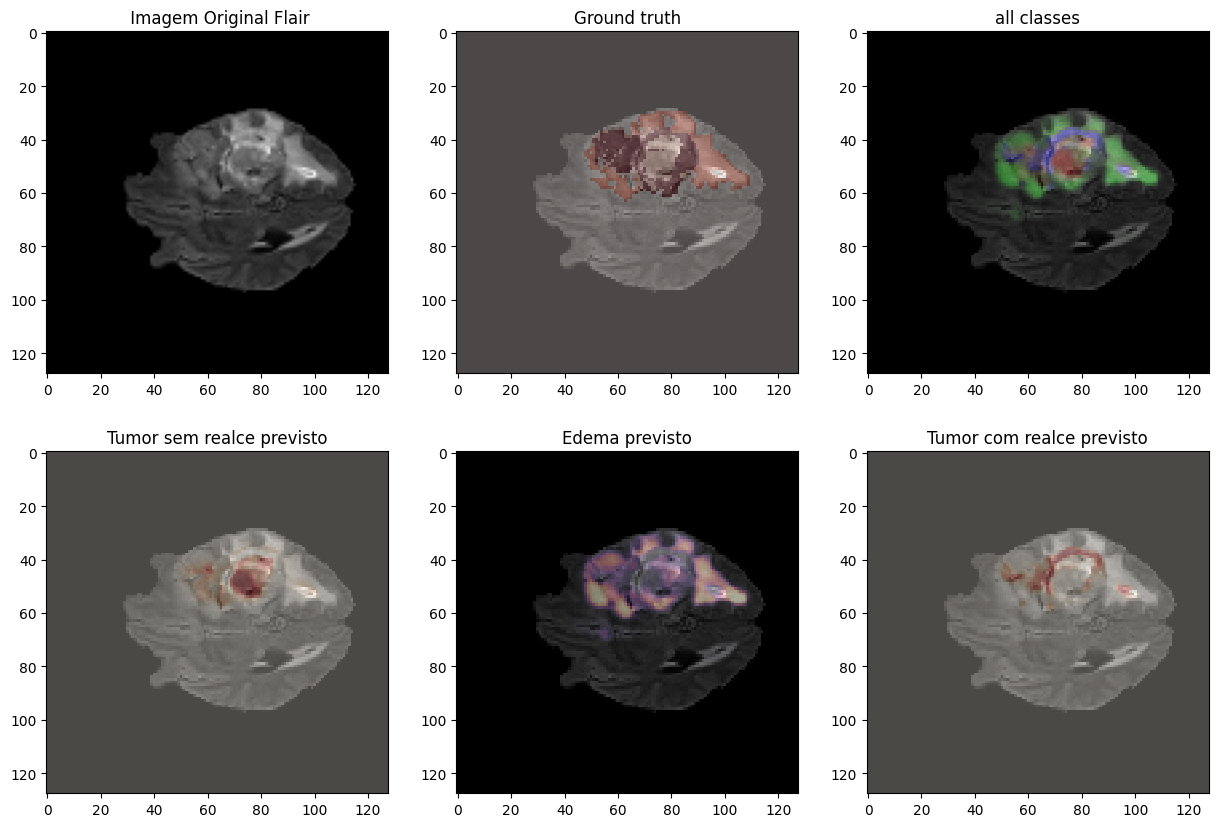

4/4 [==============================] - 1s 302ms/step


<Figure size 1800x5000 with 0 Axes>

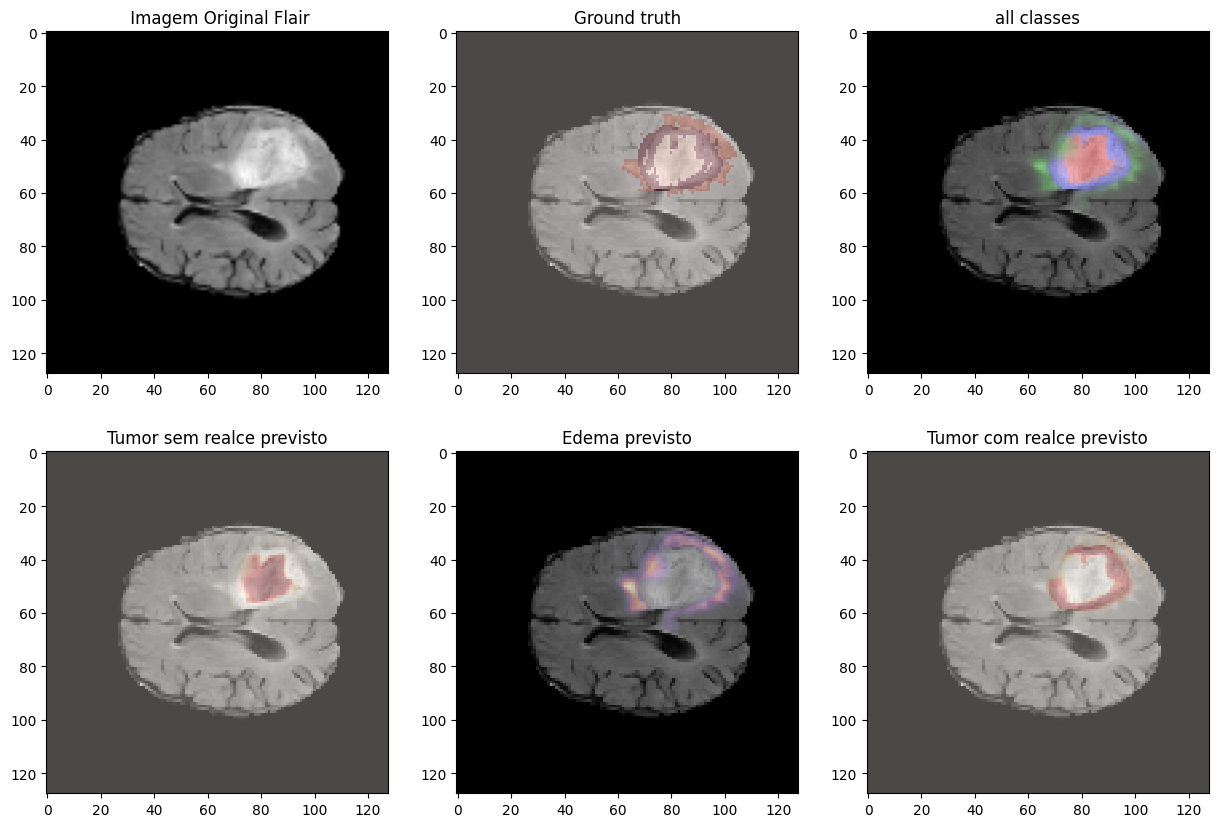

4/4 [==============================] - 1s 292ms/step


<Figure size 1800x5000 with 0 Axes>

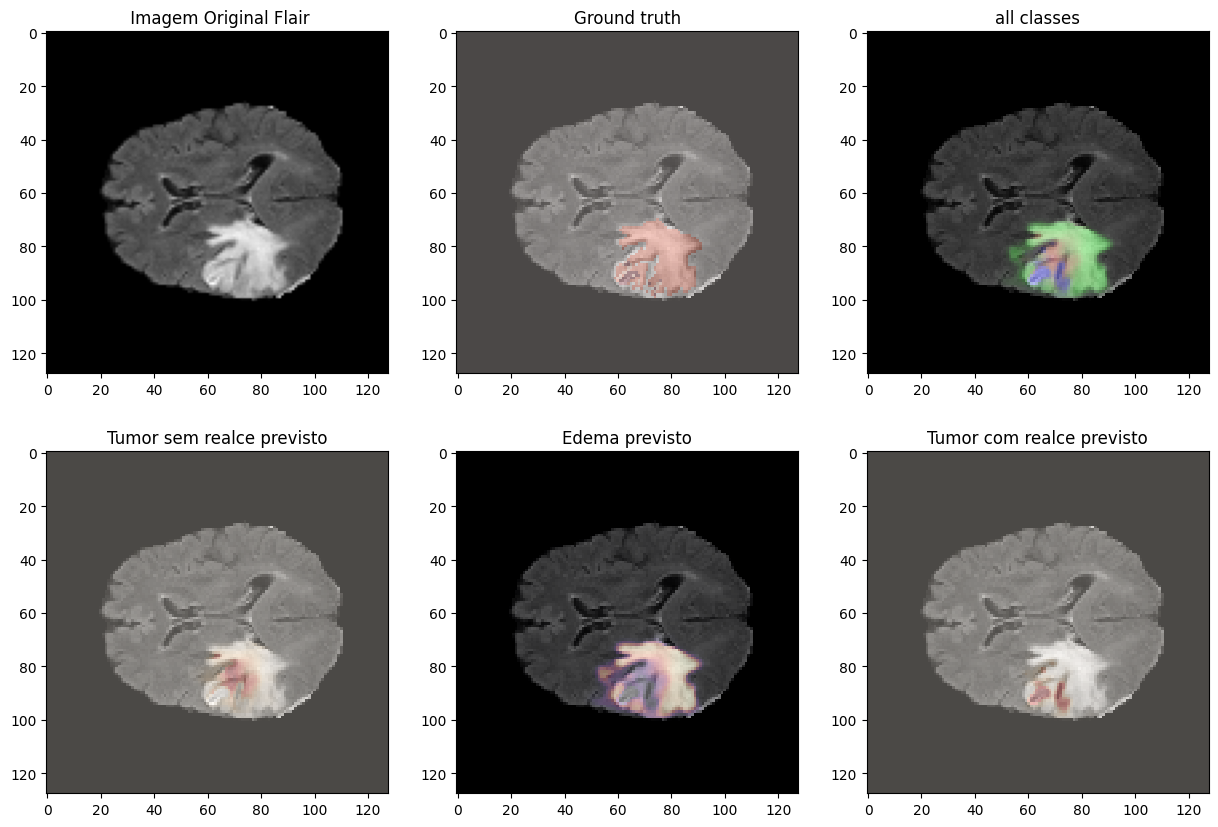

4/4 [==============================] - 1s 174ms/step


<Figure size 1800x5000 with 0 Axes>

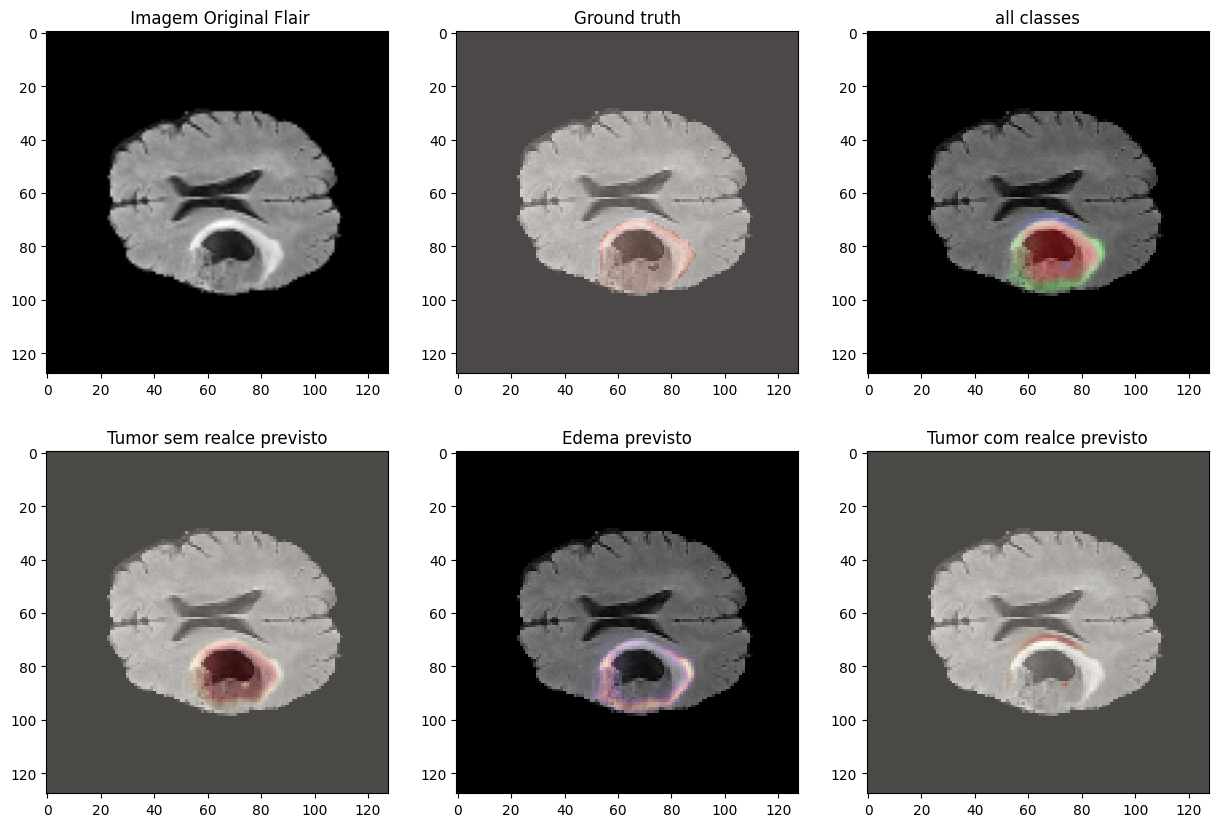

4/4 [==============================] - 1s 490ms/step


<Figure size 1800x5000 with 0 Axes>

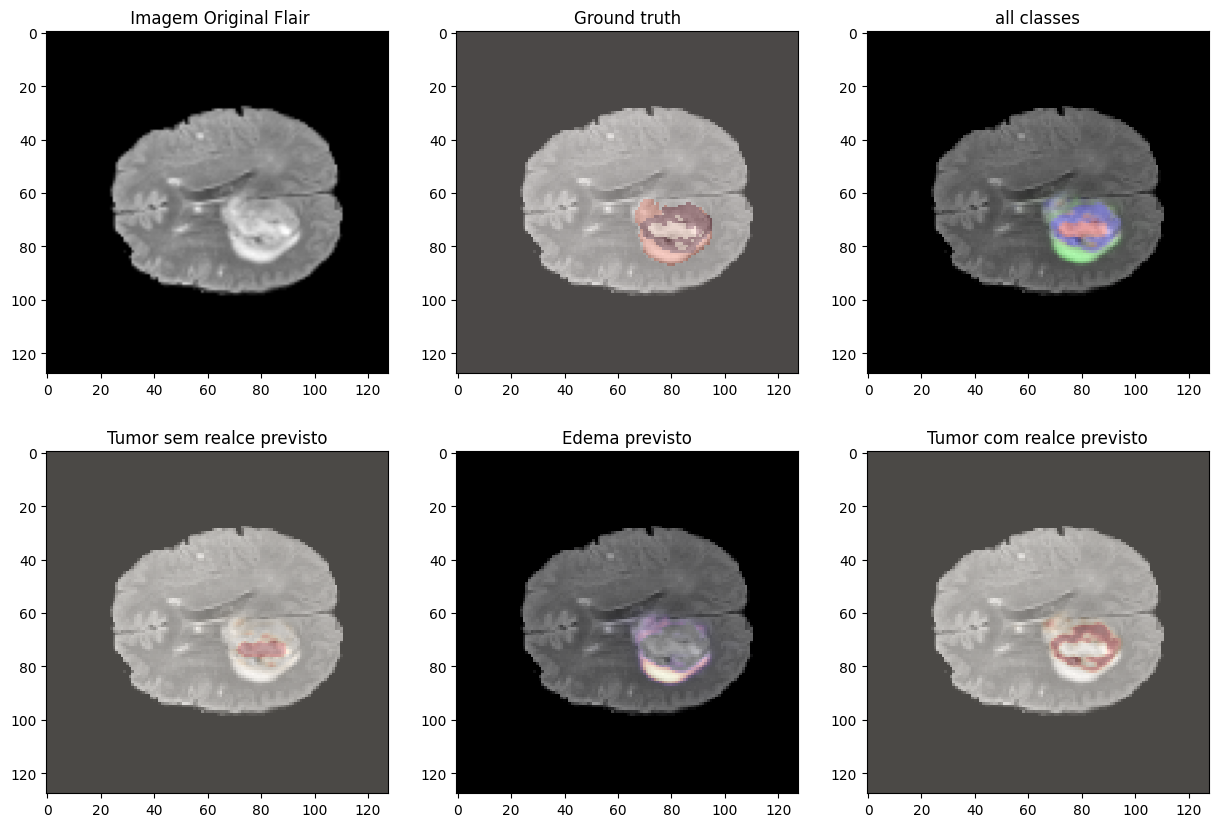

4/4 [==============================] - 1s 323ms/step


<Figure size 1800x5000 with 0 Axes>

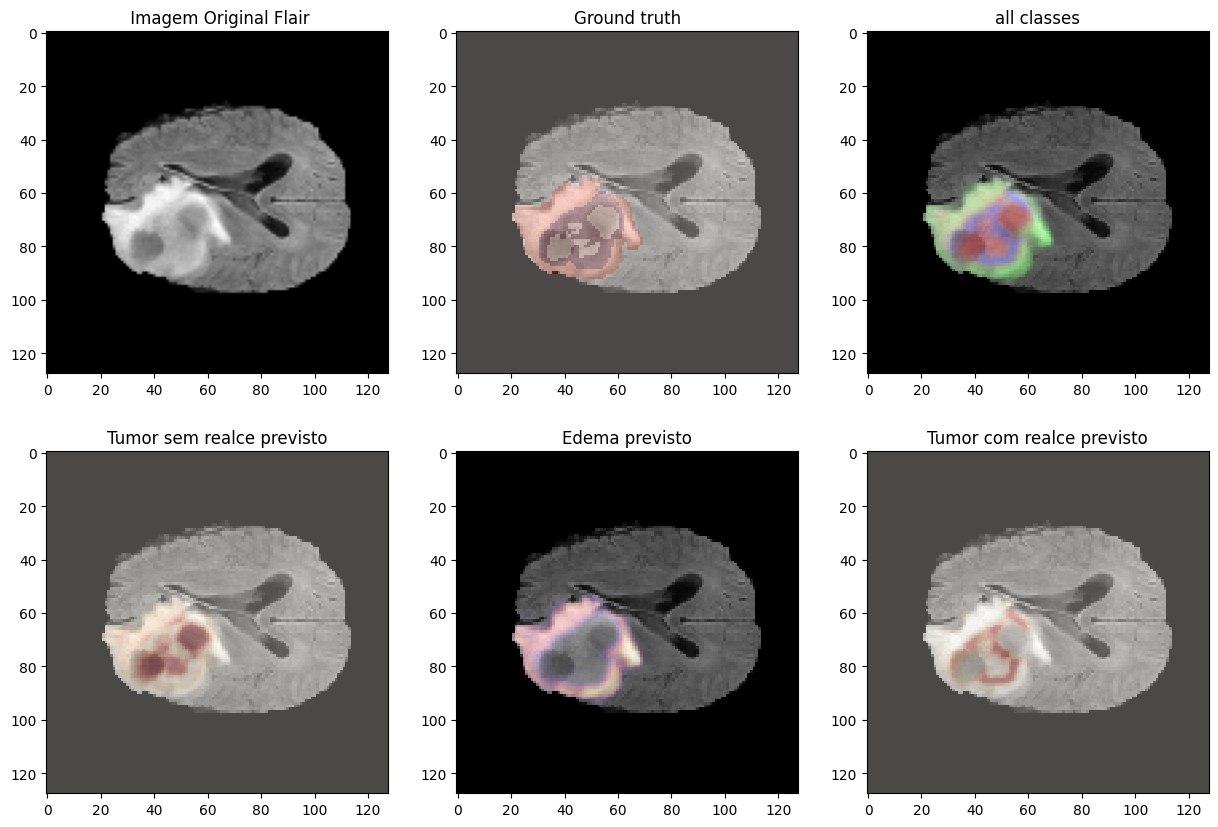

4/4 [==============================] - 2s 513ms/step


<Figure size 1800x5000 with 0 Axes>

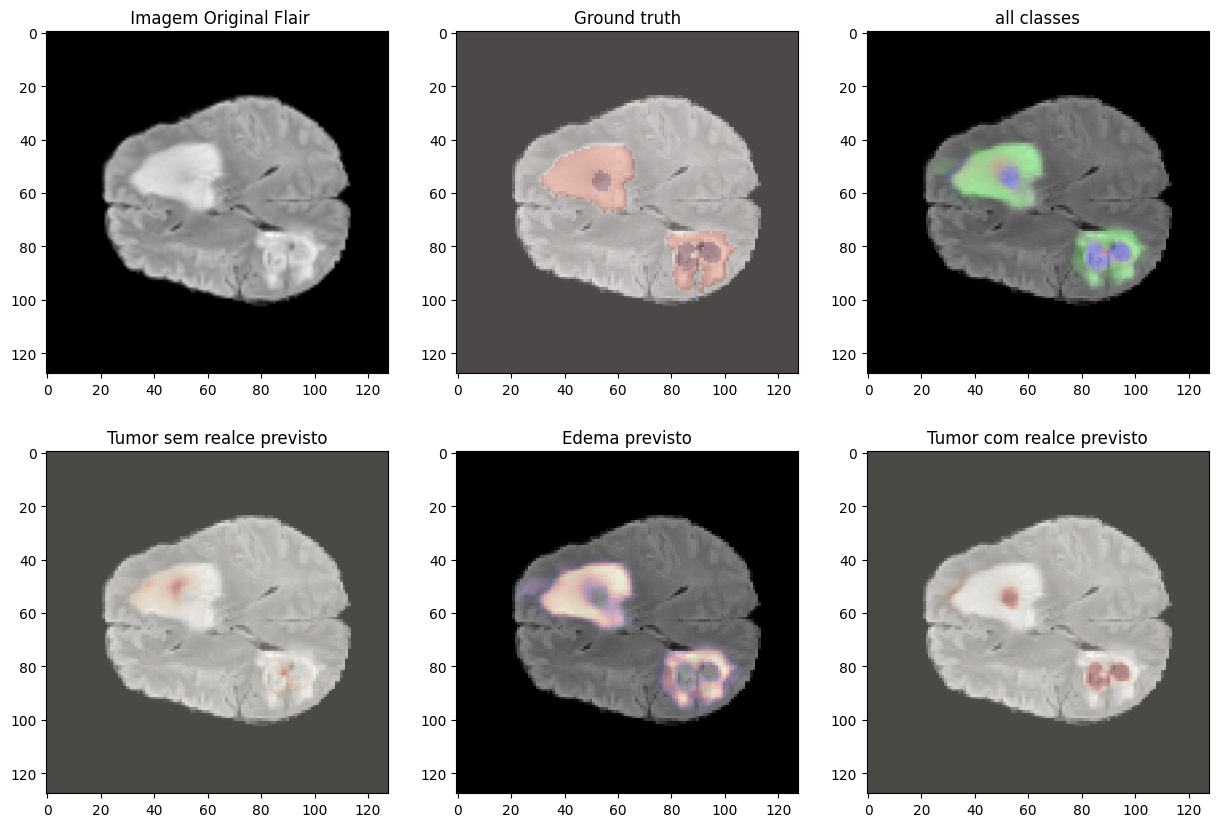

4/4 [==============================] - 2s 505ms/step


<Figure size 1800x5000 with 0 Axes>

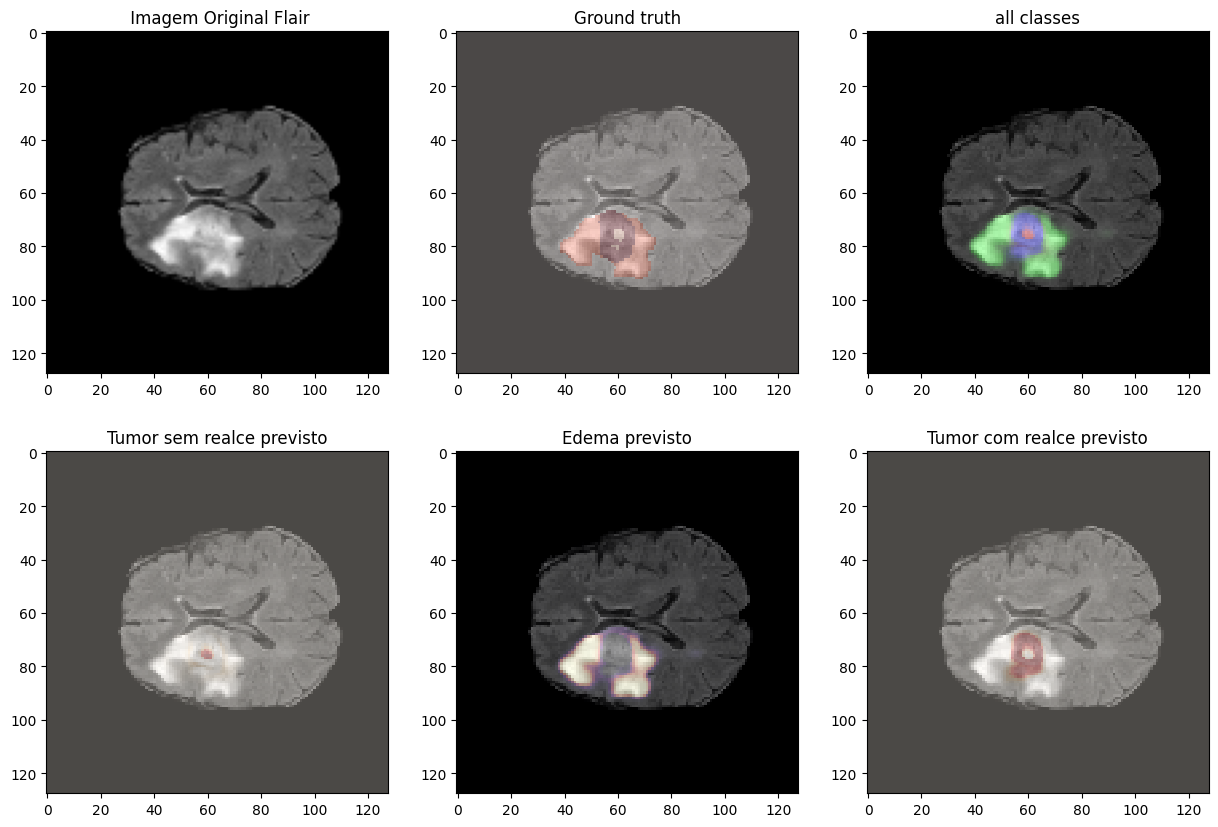

In [ ]:
showPredictsById("00"+str(numcase),46)
showPredictsById(case=test_ids[10][-3:])
showPredictsById(case=test_ids[12][-3:])
showPredictsById(case=test_ids[22][-3:])
showPredictsById(case=test_ids[14][-3:])
showPredictsById(case=test_ids[23][-3:])
showPredictsById(case=test_ids[44][-3:])
showPredictsById(case=test_ids[35][-3:])

In [ ]:
showPredictsById(case=test_ids[7][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


In [ ]:
mask = np.zeros((10,10))
mask[3:-3, 3:-3] = 1 # white square in black background
im = mask + np.random.randn(10,10) * 0.01 # random image
masked = np.ma.masked_where(mask == 0, mask)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.9)
plt.show()

In [ ]:
!pip install config

In [ ]:
import time
import config
import albumentations as A
import nibabel as nib
class ImageReader:
    def __init__(self,data_root, img_size:int=256, normalize:bool=False, single_class:bool=False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=data_root

    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            if self.normalize:
                if frame.max() > 0:
                    frame = frame/frame.max()
                frame = frame.astype(np.float32)
            else:
                frame = frame.astype(np.uint8)
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(1*(resized['mask'] > 0) if self.single_class else resized['mask'])
        return {
            'scan': np.stack(processed_frames, 0),
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }

    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(1).zfill(3)
        scan_filename = f'{self.root}/BraTS20_Training_00{numcase}_flair.nii'
        return self.read_file(scan_filename)

import plotly.graph_objects as go
import numpy as np
import plotly


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader, mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale

    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 si 1/5 pixeli pentru clasele tumorii  1(nucleu necrotic), 2(edem) si 4(tumoare de amplificare)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)

        import pandas as pd                   #For surface points
        from scipy.spatial import Delaunay
        # Combine x, y, and z into a list of (x, y, z) tuples
        points = np.array(list(zip(clean_mri['x'],clean_mri['y'],clean_mri['z'])))
        # Compute the Delaunay triangulation
        triangulation = Delaunay(points)
        # Get the indices of the triangles forming the convex hull
        convex_hull_indices = triangulation.convex_hull
        # Flatten the indices to get a list of all surface points
        surface_indices = np.unique(convex_hull_indices.flatten())
        # Extract the surface points from the original list
        surface_points = points[surface_indices]
        arx = []
        ary = []
        arz = []
        for point in surface_points:
          if(point[2]>50):
            arx.append(point[0])
            ary.append(point[1])
            arz.append(point[2])
    #Shortest path

        mind=9999
        minx=0
        miny=0
        minz=0
        import math

        def calculate_3d_distance(point1, point2):
                x1, y1, z1 = point1
                x2, y2, z2 = point2
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
                return distance
        xx= np.mean(tumors[1]['x'])
        yy= np.mean(tumors[1]['y'])
        zz= np.mean(tumors[1]['z'])
        for point in surface_points:
              if(point[2]>45):
                p1=[point[0],point[1],point[2]]
                p2=[xx, yy, zz]
                t = calculate_3d_distance(p1,p2)
                if(mind>t):
                  mind=t
                  minx=point[0]
                  miny=point[1]
                  minz=point[2]

        ax=[minx,xx]
        ay=[miny,yy]
        az=[minz,zz]


        return [
            generate_3d_scatter(**clean_mri, scale=self.mri_colorscale, opacity=0.3, hover='skip', name='Brain MRI'),
            generate_3d_scatter(**tumors[1], opacity=0.90, hover='all', name='Necrotic tumor core'),
            generate_3d_scatter(**tumors[2], opacity=0.05, hover='all', name='Peritumoral invaded tissue'),
            generate_3d_scatter(**tumors[4], opacity=0.30, hover='all', name='GD-enhancing tumor'),
            go.Scatter3d(x=ax, y=ay, z=az, mode='lines+markers', marker=dict(size=12, color='blue'), name='Path for tumor'),
        ], markers_created
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0,r=0,b=0,t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig


data_root = f'{DATA_PATH}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_00{numcase}'
# tumour visualization time starts(tv0)
tv0 = time.time()
reader = ImageReader(data_root, img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=25)

fig = viewer.get_3d_scan(numcase, 'flair')
plotly.offline.iplot(fig)

### **Análise entre as duas equações aplicadas de perda (ECC e a ECC + SDL)**

In [ ]:
# Caminho para o arquivo Excel que contém todas as métricas dos melhores treinamentos com a Perda Entropia Cruzada Categórica combinada com Perda Suave Dice (ECC+SDL) e a Perda Entropia Cruzada Categórica (ECC)
caminho_arquivo = '/content/drive/MyDrive/IRM/Task01_BrainTumour/archive/model_x80_dcs65/Book1.xlsx'

# Ler o arquivo Excel
dados_excel = pd.read_excel(caminho_arquivo, sheet_name='434547')


In [ ]:
print(dados_excel)

In [ ]:
# Remover linhas com valores NaN
dados_limpos = dados_excel.dropna()

# Exibir os dados limpos
print(dados_limpos)

    epoch  accuracy-43  accuracy-45  accuracy-47   loss-43   loss-45  \
0       0     0.979219     0.980713     0.983191  0.196153  0.110989   
1       1     0.983039     0.982662     0.983217  0.080079  0.071540   
2       2     0.983152     0.982358     0.983400  0.070621  0.070797   
3       3     0.982987     0.982666     0.985112  0.068213  0.066481   
4       4     0.986205     0.983365     0.986039  0.052336  0.059147   
5       5     0.987542     0.983342     0.987122  0.045932  0.057038   
6       6     0.987870     0.984173     0.987085  0.043170  0.049214   
7       7     0.988543     0.987413     0.988510  0.039524  0.040512   
8       8     0.989050     0.988077     0.988589  0.036782  0.037112   
9       9     0.989485     0.988939     0.989906  0.035740  0.033384   
10     10     0.990132     0.989308     0.990294  0.032494  0.031536   
11     11     0.990331     0.989744     0.990358  0.030859  0.030328   
12     12     0.990709     0.990243     0.986821  0.028962  0.02

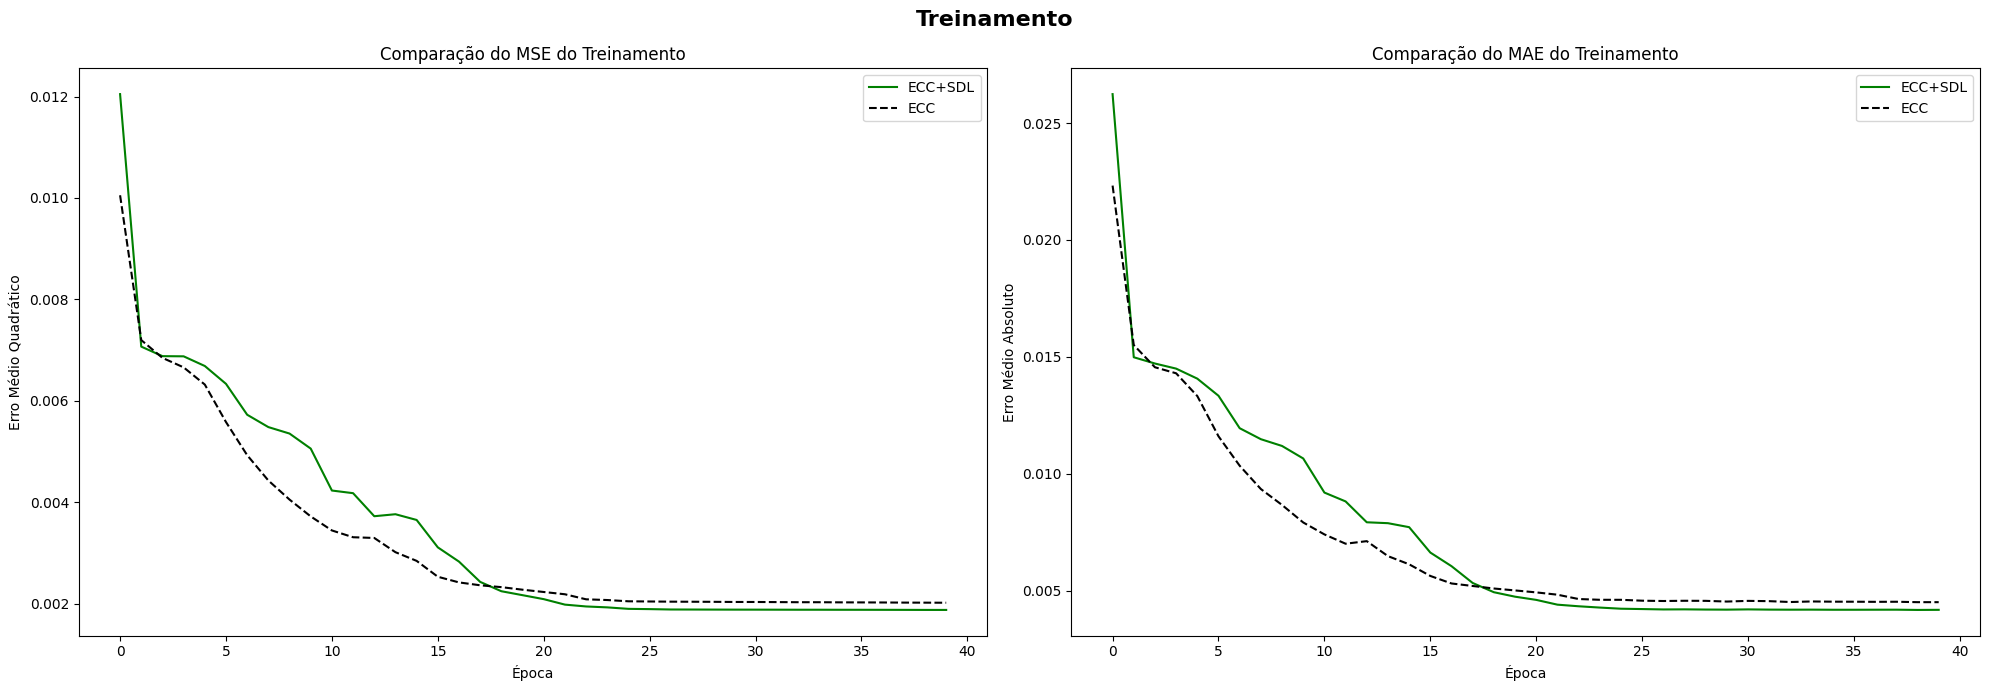

In [ ]:
# ERRO QUADRATICO E ABSOLUTO

mean_squared_error43 = dados_limpos['mean_squared_error-42']
mean_squared_error45 = dados_limpos['mean_squared_error-44']
mean_squared_error47 = dados_limpos['mean_squared_error-51']

mean_absolute_error43 = dados_limpos['mean_absolute_error-42']
mean_absolute_error45 = dados_limpos['mean_absolute_error-44']
mean_absolute_error47 = dados_limpos['mean_absolute_error-51']
epoch = dados_limpos['epoch']

# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, mean_squared_error43, 'g', label='ECC+SDL')
#ax1[0].plot(epoch, mean_squared_error45, 'y', label='ECC+SR')
ax1[0].plot(epoch, mean_squared_error47, 'k--', label='ECC')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Erro Médio Quadrático')
ax1[0].set_title('Comparação do MSE do Treinamento')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, mean_absolute_error43, 'g', label='ECC+SDL')
#ax1[1].plot(epoch, mean_absolute_error45, 'y', label='ECC+SR')
ax1[1].plot(epoch, mean_absolute_error47, 'k--', label='ECC')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Erro Médio Absoluto')
ax1[1].set_title('Comparação do MAE do Treinamento')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Treinamento', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

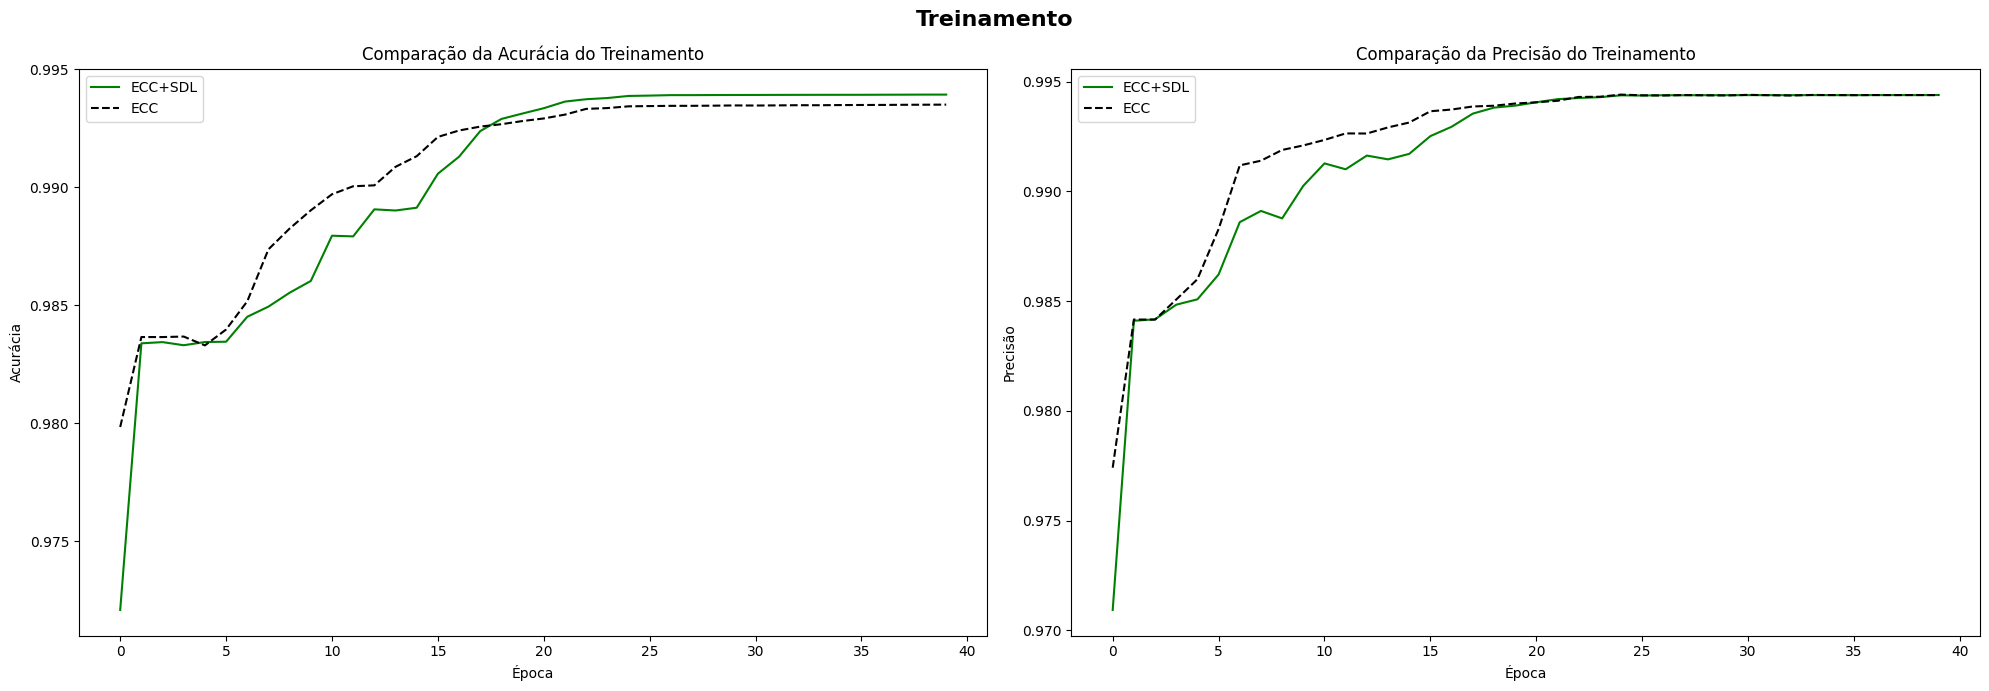

In [ ]:
# Acurácia e Precisão

accuracy43 = dados_limpos['accuracy-42']
accuracy45 = dados_limpos['accuracy-44']
accuracy47 = dados_limpos['accuracy-51']

precision43 = dados_limpos['precision-42']
precision45 = dados_limpos['precision-44']
precision47 = dados_limpos['precision-51']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, accuracy43, 'g', label='ECC+SDL')
#ax1[0].plot(epoch, accuracy45, 'y', label='ECC+SR')
ax1[0].plot(epoch, accuracy47, 'k--', label='ECC')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Acurácia')
ax1[0].set_title('Comparação da Acurácia do Treinamento')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, precision43, 'g', label='ECC+SDL')
#ax1[1].plot(epoch, precision45, 'y', label='ECC+SR')
ax1[1].plot(epoch, precision47, 'k--', label='ECC')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Precisão')
ax1[1].set_title('Comparação da Precisão do Treinamento')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Treinamento', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

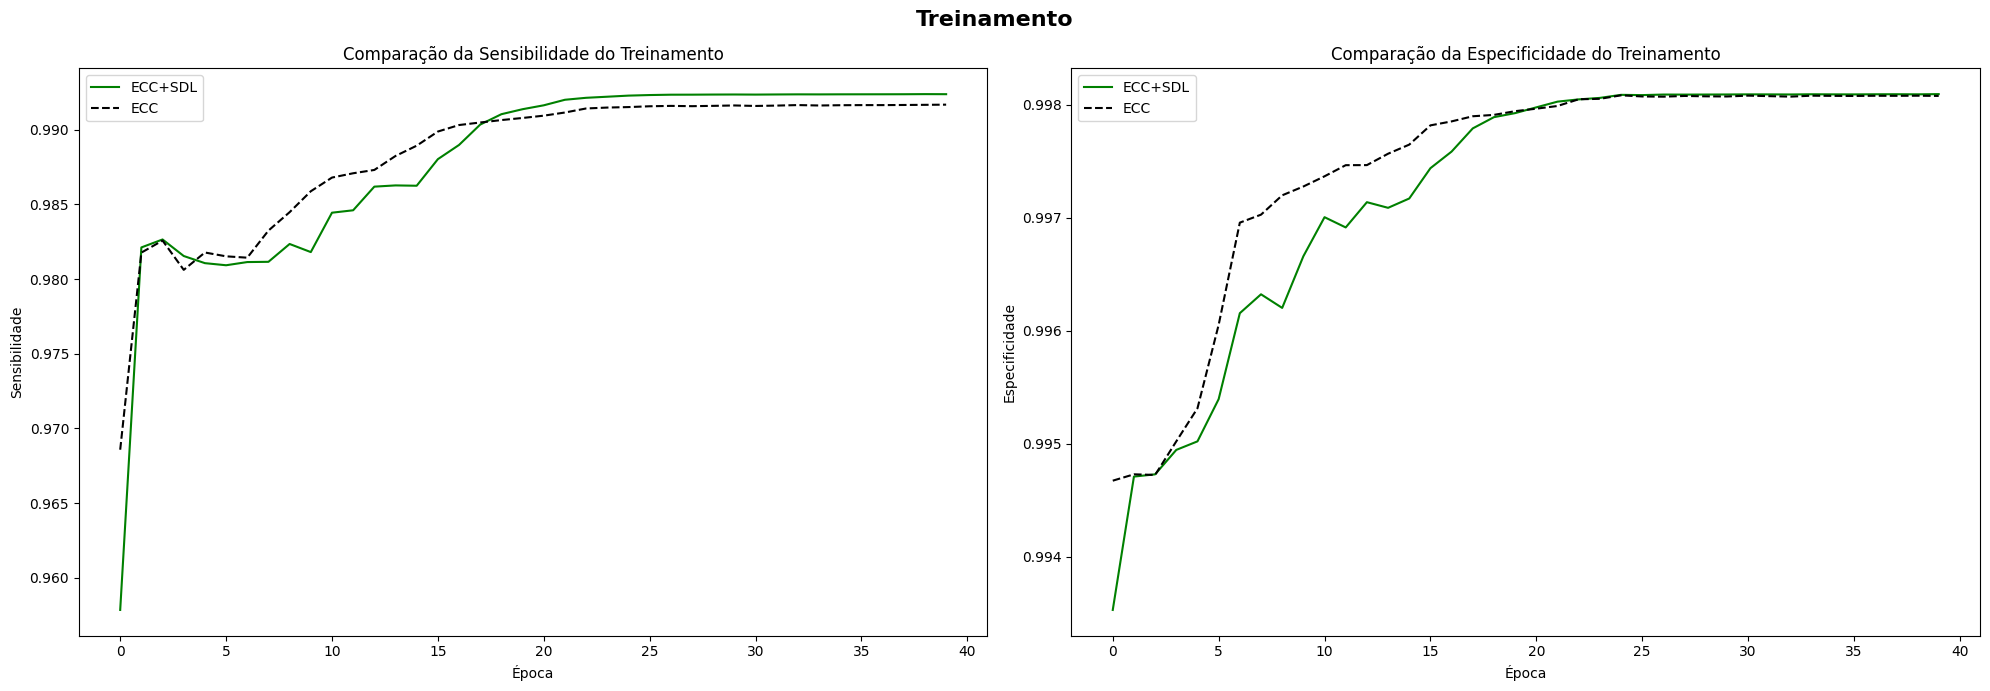

In [ ]:
# sensitivity e Especificidade

sensitivity43 = dados_limpos['sensitivity-42']
sensitivity45 = dados_limpos['sensitivity-44']
sensitivity47 = dados_limpos['sensitivity-51']

specificity43 = dados_limpos['specificity-42']
specificity45 = dados_limpos['specificity-44']
specificity47 = dados_limpos['specificity-51']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, sensitivity43, 'g', label='ECC+SDL')
#ax1[0].plot(epoch, sensitivity45, 'y', label='ECC+SR')
ax1[0].plot(epoch, sensitivity47, 'k--', label='ECC')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Sensibilidade')
ax1[0].set_title('Comparação da Sensibilidade do Treinamento')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, specificity43, 'g', label='ECC+SDL')
#ax1[1].plot(epoch, specificity45, 'y', label='ECC+SR')
ax1[1].plot(epoch, specificity47, 'k--', label='ECC')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Especificidade')
ax1[1].set_title('Comparação da Especificidade do Treinamento')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Treinamento', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

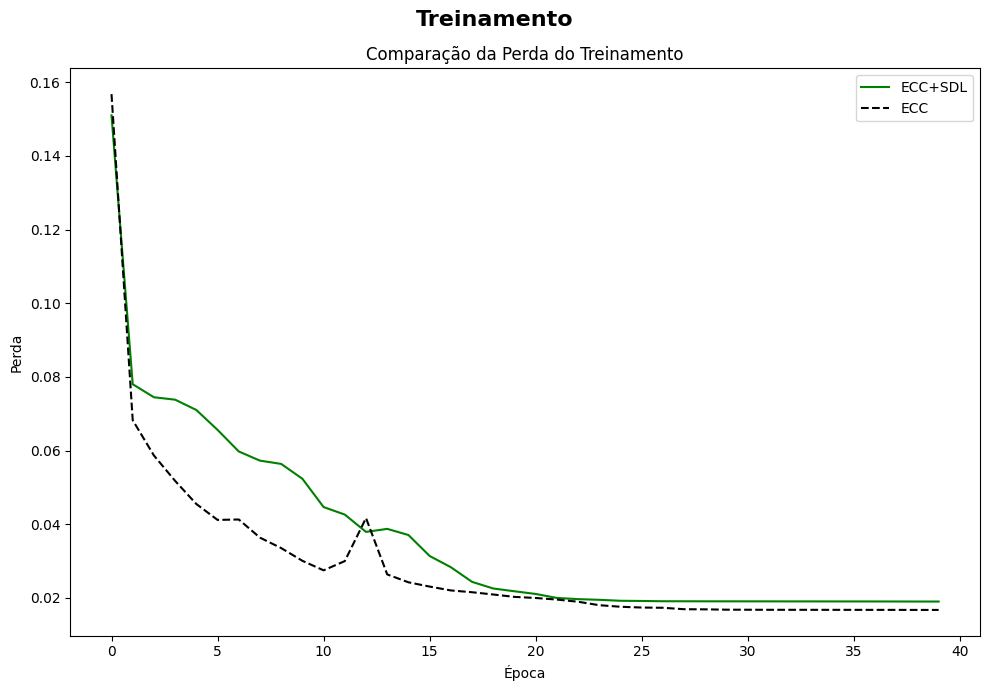

In [ ]:
# Perda

loss43 = dados_limpos['loss-42']
loss47 = dados_limpos['loss-47']
loss45 = dados_limpos['loss-51']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(figsize=(10, 7))

# Gráfico 1: Erro Médio Quadrático
ax1.plot(epoch, loss43, 'g', label='ECC+SDL')
#ax1.plot(epoch, loss45, 'y', label='ECC+SR')
ax1.plot(epoch, loss47, 'k--', label='ECC')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.set_title('Comparação da Perda do Treinamento')
ax1.legend()




# Adicione um título geral
plt.suptitle('Treinamento', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

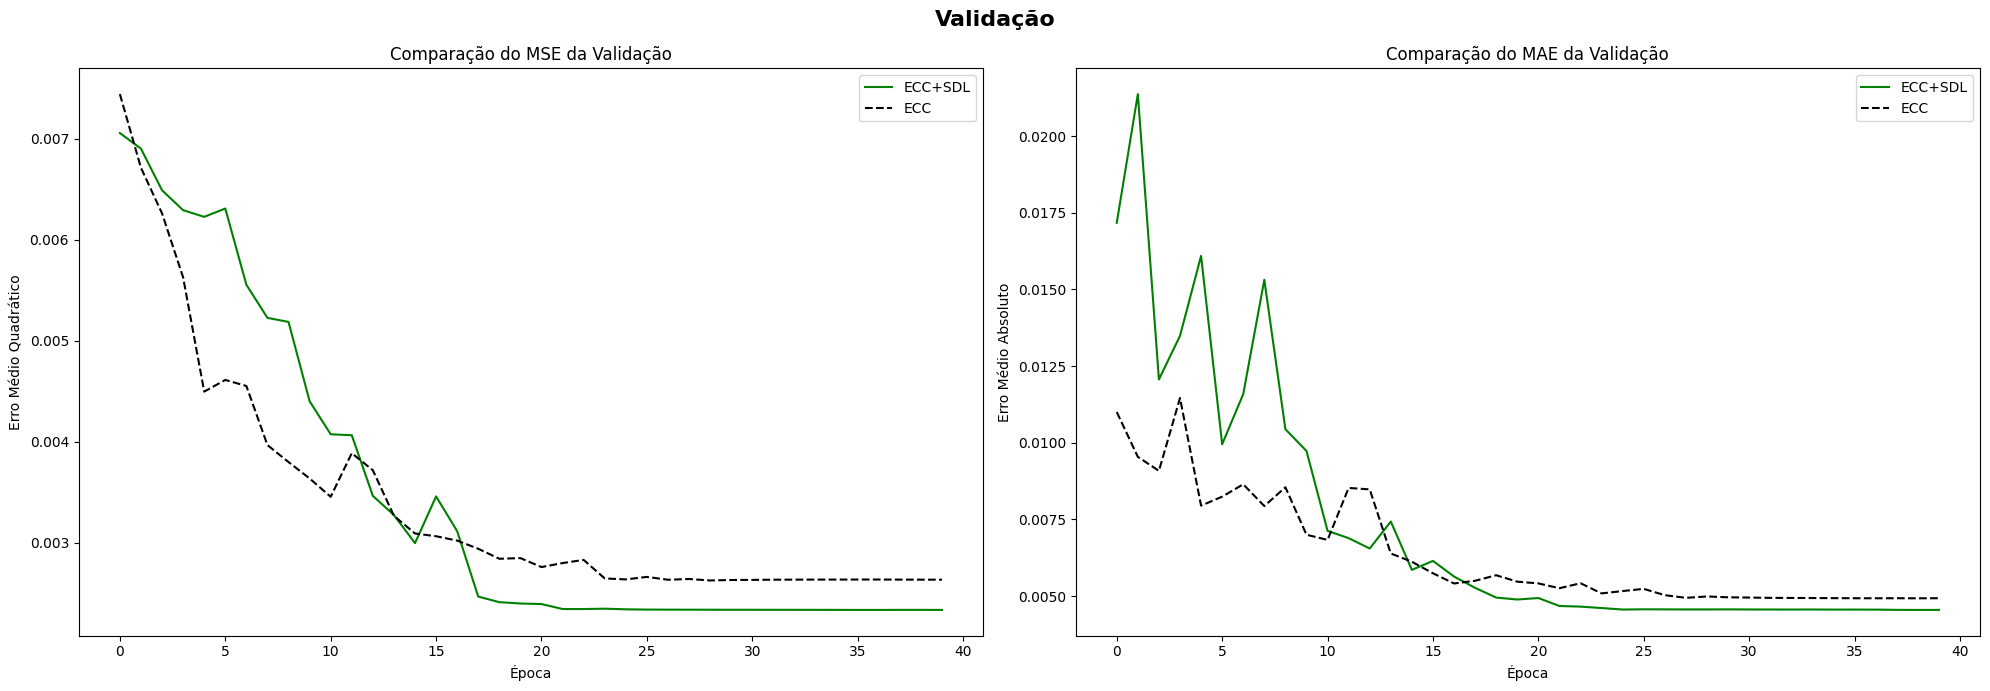

In [ ]:
# ERRO QUADRATICO E ABSOLUTO

mean_squared_error43 = dados_limpos['val_mean_squared_error-42']
mean_squared_error47 = dados_limpos['val_mean_squared_error-47']
mean_squared_error44 = dados_limpos['val_mean_squared_error-51']

mean_absolute_error43 = dados_limpos['val_mean_absolute_error-42']
mean_absolute_error47 = dados_limpos['val_mean_absolute_error-47']
mean_absolute_error44 = dados_limpos['val_mean_squared_error-51']

# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, mean_squared_error43, 'g', label='ECC+SDL')
ax1[0].plot(epoch, mean_squared_error47, 'k--', label='ECC')
#ax1[0].plot(epoch, mean_squared_error44, 'y', label='44')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Erro Médio Quadrático')
ax1[0].set_title('Comparação do MSE da Validação')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, mean_absolute_error43, 'g', label='ECC+SDL')
ax1[1].plot(epoch, mean_absolute_error47, 'k--', label='ECC')
#ax1[1].plot(epoch, mean_absolute_error44, 'y', label='44')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Erro Médio Absoluto')
ax1[1].set_title('Comparação do MAE da Validação')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Validação', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

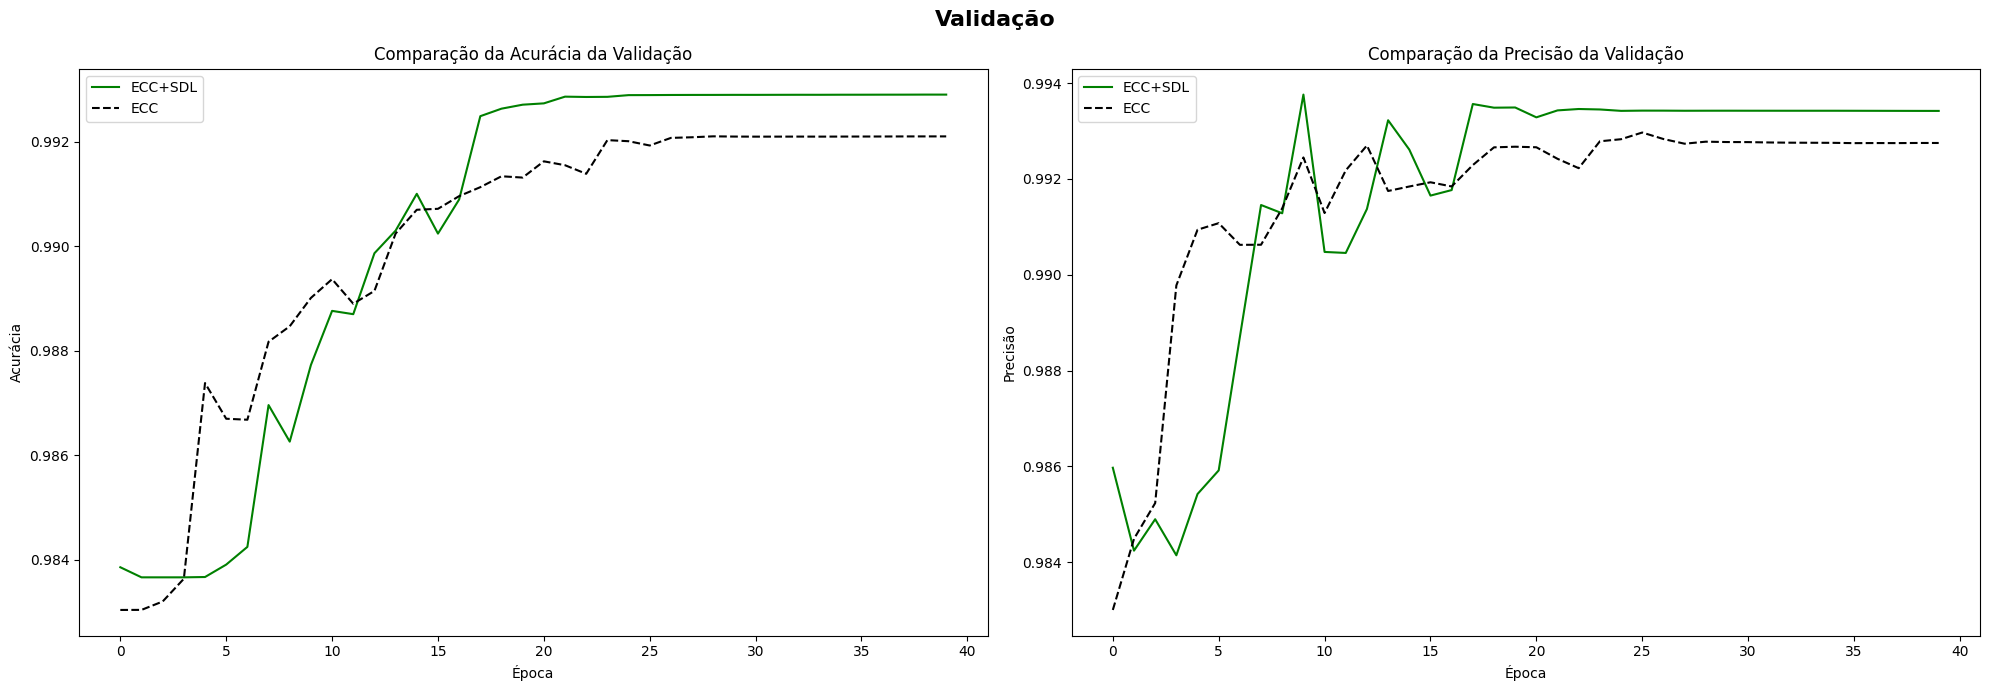

In [ ]:
# Acurácia e Precisão

accuracy43 = dados_limpos['val_accuracy-42']
accuracy47 = dados_limpos['val_accuracy-47']
accuracy44 = dados_limpos['val_accuracy-51']

precision43 = dados_limpos['val_precision-42']
precision47 = dados_limpos['val_precision-47']
precision44 = dados_limpos['val_precision-51']

# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, accuracy43, 'g', label='ECC+SDL')
#ax1[0].plot(epoch, accuracy44, 'y', label='44')
ax1[0].plot(epoch, accuracy47, 'k--', label='ECC')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Acurácia')
ax1[0].set_title('Comparação da Acurácia da Validação')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, precision43, 'g', label='ECC+SDL')
#ax1[1].plot(epoch, precision44, 'y', label='44')
ax1[1].plot(epoch, precision47, 'k--', label='ECC')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Precisão')
ax1[1].set_title('Comparação da Precisão da Validação')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Validação', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

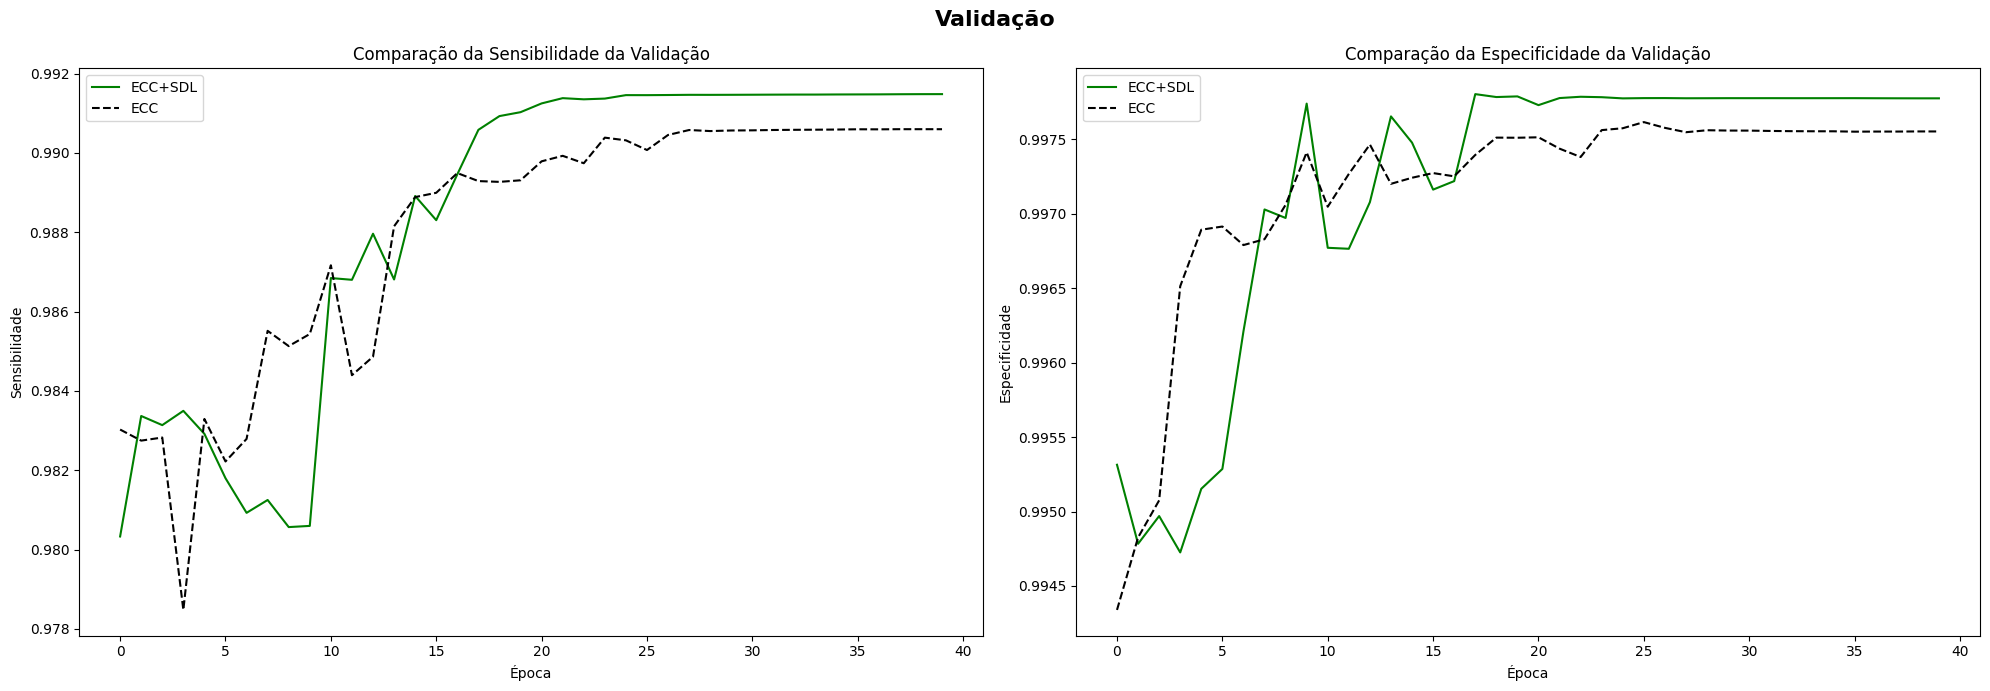

In [ ]:
# sensitivity e Especificidade

sensitivity43 = dados_limpos['val_sensitivity-42']
sensitivity47 = dados_limpos['val_sensitivity-47']
sensitivity44 = dados_limpos['val_sensitivity-51']

specificity43 = dados_limpos['val_specificity-42']
specificity47 = dados_limpos['val_specificity-47']
specificity44 = dados_limpos['val_specificity-51']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico 1: Erro Médio Quadrático
ax1[0].plot(epoch, sensitivity43, 'g', label='ECC+SDL')
#ax1[0].plot(epoch, sensitivity44, 'y', label='44')
ax1[0].plot(epoch, sensitivity47, 'k--', label='ECC')
ax1[0].set_xlabel('Época')
ax1[0].set_ylabel('Sensibilidade')
ax1[0].set_title('Comparação da Sensibilidade da Validação')
ax1[0].legend()

# Gráfico 2: Erro Médio Absoluto
ax1[1].plot(epoch, specificity43, 'g', label='ECC+SDL')
#ax1[1].plot(epoch, specificity44, 'y', label='44')
ax1[1].plot(epoch, specificity47, 'k--', label='ECC')
ax1[1].set_xlabel('Época')
ax1[1].set_ylabel('Especificidade')
ax1[1].set_title('Comparação da Especificidade da Validação')
ax1[1].legend()



# Adicione um título geral
plt.suptitle('Validação', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()

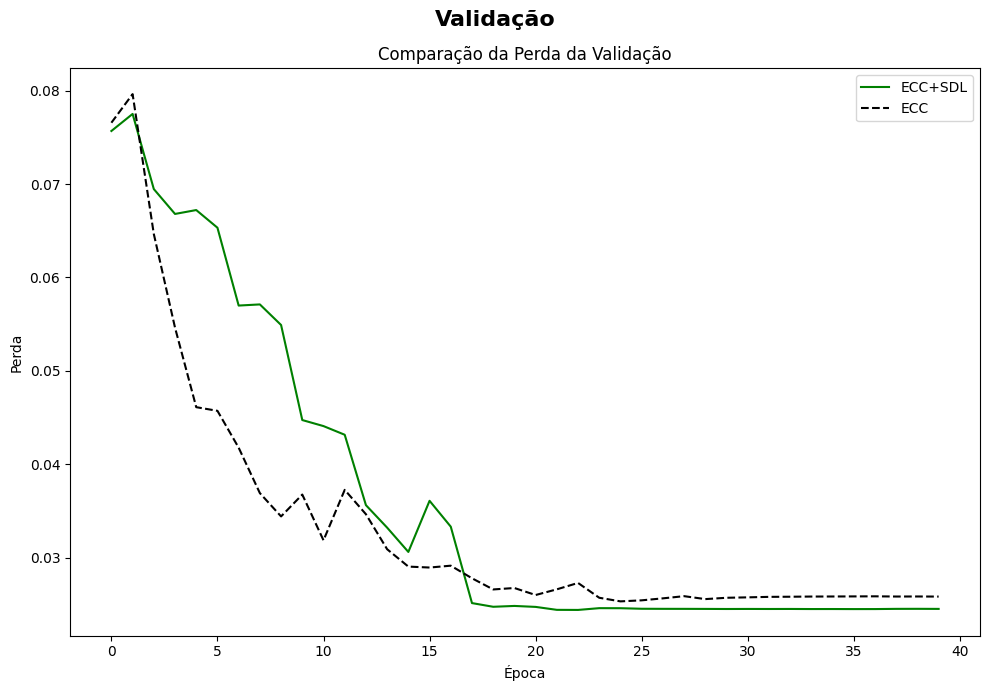

In [ ]:
# Perda

loss43 = dados_limpos['val_loss-42']
loss47 = dados_limpos['val_loss-47']
loss44 = dados_limpos['val_loss-51']


# Crie uma figura com subplots
fig1, ax1 = plt.subplots(figsize=(10, 7))

# Gráfico 1: Erro Médio Quadrático
ax1.plot(epoch, loss43, 'g', label='ECC+SDL')
#ax1.plot(epoch, loss44, 'y', label='44')
ax1.plot(epoch, loss47, 'k--', label='ECC')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.set_title('Comparação da Perda da Validação')
ax1.legend()




# Adicione um título geral
plt.suptitle('Validação', fontsize=16, fontweight='bold')


# Ajuste o layout
plt.tight_layout()

# Exibir a figura

plt.show()